In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, scipy
import anndata
from typing import Dict, Optional
import tables
import scipy.sparse as sp
import scvelo as scv
import scanpy.external as sce
%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri
import rpy2.robjects.numpy2ri
#import numpy2ri

pandas2ri.activate()
anndata2ri.activate()
rpy2.robjects.numpy2ri.activate()

%load_ext rpy2.ipython

# Read CellBender output

In [2]:
def dict_from_h5(file: str) -> Dict[str, np.ndarray]:
    """Read in everything from an h5 file and put into a dictionary.

    Args:
        file: The h5 file

    Returns:
        Dictionary containing all the information from the h5 file
    """
    d = {}
    with tables.open_file(file) as f:
        # read in everything
        for array in f.walk_nodes("/", "Array"):
            d[array.name] = array.read()
    return d

def _fill_adata_slots_automatically(adata, d):
    """Add other information to the adata object in the appropriate slot."""

    # TODO: what about "features_analyzed_inds"?  If not all features are analyzed, does this work?

    for key, value in d.items():
        try:
            if value is None:
                continue
            value = np.asarray(value)
            if len(value.shape) == 0:
                adata.uns[key] = value
            elif value.shape[0] == adata.shape[0]:
                if (len(value.shape) < 2) or (value.shape[1] < 2):
                    adata.obs[key] = value
                else:
                    adata.obsm[key] = value
            elif value.shape[0] == adata.shape[1]:
                if value.dtype.name.startswith('bytes'):
                    adata.var[key] = value.astype(str)
                else:
                    adata.var[key] = value
            else:
                adata.uns[key] = value
        except Exception:
            print('Unable to load data into AnnData: ', key, value, type(value))

def anndata_from_h5(file: str,
                    analyzed_barcodes_only: bool = True) -> anndata.AnnData:
    """Load an output h5 file into an AnnData object for downstream work.

    Args:
        file: The h5 file
        analyzed_barcodes_only: False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.

    Returns:
        anndata.AnnData: The anndata object, populated with inferred latent variables
            and metadata.

    """

    d = dict_from_h5(file)
    X = sp.csc_matrix((d.pop('data'), d.pop('indices'), d.pop('indptr')),
                      shape=d.pop('shape')).transpose().tocsr()

    # check and see if we have barcode index annotations, and if the file is filtered
    barcode_key = [k for k in d.keys() if (('barcode' in k) and ('ind' in k))]
    if len(barcode_key) > 0:
        max_barcode_ind = d[barcode_key[0]].max()
        filtered_file = (max_barcode_ind >= X.shape[0])
    else:
        filtered_file = True

    if analyzed_barcodes_only:
        if filtered_file:
            # filtered file being read, so we don't need to subset
            print('Assuming we are loading a "filtered" file that contains only cells.')
            pass
        elif 'barcode_indices_for_latents' in d.keys():
            X = X[d['barcode_indices_for_latents'], :]
            d['barcodes'] = d['barcodes'][d['barcode_indices_for_latents']]
        elif 'barcodes_analyzed_inds' in d.keys():
            X = X[d['barcodes_analyzed_inds'], :]
            d['barcodes'] = d['barcodes'][d['barcodes_analyzed_inds']]
        else:
            print('Warning: analyzed_barcodes_only=True, but the key '
                  '"barcodes_analyzed_inds" or "barcode_indices_for_latents" '
                  'is missing from the h5 file. '
                  'Will output all barcodes, and proceed as if '
                  'analyzed_barcodes_only=False')

    # Construct the anndata object.
    adata = anndata.AnnData(X=X,
                            obs={'barcode': d.pop('barcodes').astype(str)},
                            var={'gene_name': (d.pop('gene_names') if 'gene_names' in d.keys()
                                               else d.pop('name')).astype(str)},
                            dtype=X.dtype)
    adata.obs.set_index('barcode', inplace=True)
    adata.var.set_index('gene_name', inplace=True)

    # For CellRanger v2 legacy format, "gene_ids" was called "genes"... rename this
    if 'genes' in d.keys():
        d['id'] = d.pop('genes')

    # For purely aesthetic purposes, rename "id" to "gene_id"
    if 'id' in d.keys():
        d['gene_id'] = d.pop('id')

    # If genomes are empty, try to guess them based on gene_id
    if 'genome' in d.keys():
        if np.array([s.decode() == '' for s in d['genome']]).all():
            if '_' in d['gene_id'][0].decode():
                print('Genome field blank, so attempting to guess genomes based on gene_id prefixes')
                d['genome'] = np.array([s.decode().split('_')[0] for s in d['gene_id']], dtype=str)

    # Add other information to the anndata object in the appropriate slot.
    _fill_adata_slots_automatically(adata, d)

    # Add a special additional field to .var if it exists.
    if 'features_analyzed_inds' in adata.uns.keys():
        adata.var['cellbender_analyzed'] = [True if (i in adata.uns['features_analyzed_inds'])
                                            else False for i in range(adata.shape[1])]
    elif 'features_analyzed_inds' in adata.var.keys():
        adata.var['cellbender_analyzed'] = [True if (i in adata.var['features_analyzed_inds'].values)
                                            else False for i in range(adata.shape[1])]

    if analyzed_barcodes_only:
        for col in adata.obs.columns[adata.obs.columns.str.startswith('barcodes_analyzed')
                                     | adata.obs.columns.str.startswith('barcode_indices')]:
            try:
                del adata.obs[col]
            except Exception:
                pass
    else:
        # Add a special additional field to .obs if all barcodes are included.
        if 'barcodes_analyzed_inds' in adata.uns.keys():
            adata.obs['cellbender_analyzed'] = [True if (i in adata.uns['barcodes_analyzed_inds'])
                                                else False for i in range(adata.shape[0])]
        elif 'barcodes_analyzed_inds' in adata.obs.keys():
            adata.obs['cellbender_analyzed'] = [True if (i in adata.obs['barcodes_analyzed_inds'].values)
                                                else False for i in range(adata.shape[0])]
            
    adata.obs.index.name = None
    adata.var.index.name = None
    adata.X = adata.X.astype(np.float64)
    del adata.uns
    del adata.obsm
    adata.layers['counts'] = adata.X
    adata.var_names_make_unique()


    return adata

In [3]:
d1_adata = anndata_from_h5('CellBender_filtering/Output/D1/d1_cellbender_output_file.h5')
e1_adata = anndata_from_h5('CellBender_filtering/Output/E1/e1_cellbender_output_file.h5')
f1_adata = anndata_from_h5('CellBender_filtering/Output/F1/f1_cellbender_output_file.h5')
g1_adata = anndata_from_h5('CellBender_filtering/Output/G1/g1_cellbender_output_file.h5')
h1_adata = anndata_from_h5('CellBender_filtering/Output/H1/h1_cellbender_output_file.h5')
c2_adata = anndata_from_h5('CellBender_filtering/Output/C2/c2_cellbender_output_file.h5')
d2_adata = anndata_from_h5('CellBender_filtering/Output/D2/d2_cellbender_output_file.h5')
e2_adata = anndata_from_h5('CellBender_filtering/Output/E2/e2_cellbender_output_file.h5')
f2_adata = anndata_from_h5('CellBender_filtering/Output/F2/f2_cellbender_output_file.h5')
g2_adata = anndata_from_h5('CellBender_filtering/Output/G2/g2_cellbender_output_file.h5')
h2_adata = anndata_from_h5('CellBender_filtering/Output/H2/h2_cellbender_output_file.h5')

a6_adata = anndata_from_h5('Cell_bender_filtering/Output/A6/a6_cellbender_output_file.h5')
a7_adata = anndata_from_h5('Cell_bender_filtering/Output/A7/a7_cellbender_output_file.h5')
a9_adata = anndata_from_h5('Cell_bender_filtering/Output/A9/a9_cellbender_output_file.h5')
a11_adata = anndata_from_h5('Cell_bender_filtering/Output/A11/a11_cellbender_output_file.h5')
b5_adata = anndata_from_h5('Cell_bender_filtering/Output/B5/b5_cellbender_output_file.h5')
b6_adata = anndata_from_h5('Cell_bender_filtering/Output/B6/b6_cellbender_output_file.h5')
b7_adata = anndata_from_h5('Cell_bender_filtering/Output/B7/b7_cellbender_output_file.h5')
b8_adata = anndata_from_h5('Cell_bender_filtering/Output/B8/b8_cellbender_output_file.h5')
b10_adata = anndata_from_h5('Cell_bender_filtering/Output/B10/b10_cellbender_output_file.h5')


d1_adata_var_meta = d1_adata.var
e1_adata_var_meta = e1_adata.var
f1_adata_var_meta = f1_adata.var
g1_adata_var_meta = g1_adata.var
h1_adata_var_meta = h1_adata.var
c2_adata_var_meta = c2_adata.var
d2_adata_var_meta = d2_adata.var
e2_adata_var_meta = e2_adata.var
f2_adata_var_meta = f2_adata.var
g2_adata_var_meta = g2_adata.var
h2_adata_var_meta = h2_adata.var

a6_adata_var_meta = a6_adata.var
a7_adata_var_meta = a7_adata.var
a9_adata_var_meta = a9_adata.var
a11_adata_var_meta = a11_adata.var
b5_adata_var_meta = b5_adata.var
b6_adata_var_meta = b6_adata.var
b7_adata_var_meta = b7_adata.var
b8_adata_var_meta = b8_adata.var
b10_adata_var_meta = b10_adata.var

# Sample assignment (HTO calling)

In [4]:
%%R
library(dplyr)
library(assertthat)
library(ggplot2)
library(mclust)
library(diptest)
library(intrinsicDimension)

HTODemux.mcl <- function(object, assay = "HTO", q_l = 1, q_h = 0.005, seed = 42){
  # A function to find the threshold for each hastag, the P, and singlet, doublets and negative.
  # The input is the HTO data matrix (normalized across cells).
  
  assay <- assay %||% DefaultAssay(object = object)
  data <- GetAssayData(object = object, assay = assay, slot = 'data')
  hto.cutoff.metadata = data.frame(cut_off = future.apply::future_apply(data,1,function(x) select_hash_cutoff_mcl(x, q_l = q_l, q_h = q_h), future.seed = T))
  hto.cutoff.metadata$Multi_modal = apply(data,1,function(x) is_multimodal(x))
  hto_mcl.p = t(apply(data,1,function(x) hash_mcl_p(x, seed = seed, q_l = q_l, q_h = q_h)))
  discrete <- data
  discrete[discrete > 0] <- 0
  for (iter in rownames(x = data)) {
    values <- data[iter, ]
    cutoff <- hto.cutoff.metadata[iter,'cut_off']
    discrete[iter, names(x = which(x = values > cutoff))] <- 1
  }
  classification.metadata <- HTO_classifcation(discrete, hto_mcl.p, assay)
  object <- AddMetaData(object = object, metadata = classification.metadata)
  Idents(object) <- paste(assay, "calledFeatures", sep = '_')
  doublets <- rownames(x = object[[]])[which(object[[paste(assay, 'globalClass', sep = "_")]] == "Doublet")]
  Idents(object = object, cells = doublets) <- "Doublet"
  Idents(object) = factor(Idents(object), levels = c('Doublet', 'Negative', rownames(object@assays$HTO)))
  object$sampleID <- Idents(object = object)
  return(object)
}

is_multimodal <- function(x, p.cutoff = 1e-2) {
  # Test if the expression distribution violates unimodal distribution.
  p = diptest::dip.test(x)$p.value
  return(p < p.cutoff)
}

select_hash_cutoff_mcl <- function(x, q_l = 1, q_h = 0.01, seed = 42) {
  # Model HTO data as a mixture of two Gaussian distributions (for normalized [across cells] data)
  # And select HTO cutoff based on mclust (Model based clustering).
  assertthat::assert_that(class(x) == "numeric")
  assertthat::is.number(seed)
  assertthat::assert_that(length(seed) == 1)
  set.seed(seed)
  km <- mclust::Mclust(data = x, G = 2, verbose = F)
  cl <- km$classification
  cl_center = km$parameters$mean
  high_cl <- which(cl_center == max(cl_center))
  low_cl <- which(cl_center != max(cl_center))
  # q_l and q_h are the quantiles for negative and postive cluster, respectively. 
  cutoff <- max(quantile(x[cl == low_cl], q_l), quantile(x[cl == high_cl], q_h))
  # The higher the cut off, the less false positive (the more false negative).
  return(cutoff)
}

hash_mcl_p <- function(x, seed = 3030, q_l = 1, q_h = 0.001) {
  assertthat::assert_that(class(x) == "numeric")
  assertthat::is.number(seed)
  assertthat::assert_that(length(seed) == 1)
  set.seed(seed)
  km <- mclust::Mclust(data = x, G = 2, verbose = F)
  cl <- km$classification
  cl_center = km$parameters$mean
  high_cl <- which(cl_center == max(cl_center))
  low_cl <- which(cl_center != max(cl_center))
  p.high_cl <- km$z[,high_cl]
  # Correct assignment error from Mclust
  p.high_cl[which(x < max(quantile(cl_center[low_cl], q_l), quantile(cl_center[low_cl], q_h)))] = 0
  names(p.high_cl) = names(x)
  return(p.high_cl)
}

HTO_classifcation = function(discrete, hto_mcl.p, assay){
  # Based on HTODemux (Seurat)
  npositive <- colSums(x = discrete)
  classification.global <- npositive
  classification.global[npositive == 0] <- "Negative"
  classification.global[npositive == 1] <- "Singlet"
  classification.global[npositive > 1] <- "Doublet"
  donor.id = rownames(x = discrete)
  hash.max <- apply(X = hto_mcl.p, MARGIN = 2, FUN = max) # This returns the probability of the most likely HashID (based on the Hashtag distribution among cells)
  hash.maxID <- as.character(donor.id[apply(X = hto_mcl.p, MARGIN = 2, FUN = which.max)])
  hash.second <- apply(X = hto_mcl.p, MARGIN = 2, FUN = function(x) sort(x,decreasing = T)[2])
  hash.secondID <- as.character(donor.id[apply(X = hto_mcl.p, MARGIN = 2, FUN = function(x) order(x,decreasing = T)[2])])
  hash.margin <- hash.max - hash.second
  doublet_id <- sapply(X = 1:length(x = hash.maxID), FUN = function(x) {
    return(paste(sort(x = c(hash.maxID[x], hash.secondID[x])), 
                 collapse = "_"))
  })
  classification <- classification.global
  classification[classification.global == "Negative"] <- "Negative"
  classification[classification.global == "Singlet"] <- hash.maxID[which(x = classification.global == "Singlet")]
  classification[classification.global == "Doublet"] <- doublet_id[which(x = classification.global == "Doublet")]
  classification.metadata <- data.frame(hash.maxID, hash.secondID, hash.margin, classification, classification.global)
  colnames(x = classification.metadata) <- paste(assay, c("primaryID", "secondaryID", "margin", "calledFeatures", "globalClass"), sep = "_")
  return(classification.metadata)
}

        
                                               
my.cols <- c('Doublet' = '#E56786','Negative' = '#0000FF','Singlet' = '#7E9D00',
             'Called' = '#C1E24D','Uncalled' = '#FFB2FF', 'intra-doublet' = '#FFA500',
             'Highlight' = '#de3163','Lowlight' = '#f4b8c9','Greyneric' = '#878686')

base.size = 10
plotting.font <- 'Helvetica'

exponent_format <- function() {
  function(x) {
    parse(text = gsub("e\\+?", " %*% 10^", scales::scientific_format()(x)))
  }
}

make_plot_htoThresh <- function(hto.sample.calling.metadata, hto.cutoff.metadata, index) {
  
  hto.cutoff.metadata[['hto']] <- hto.cutoff.metadata[['hto_name']]
  
  p <- ggplot(hto.sample.calling.metadata, aes(x = expression, fill = above_cutoff)) +
    geom_histogram(bins = 100) +
    facet_wrap(~sample_id, scales = 'free',ncol = 3) +
    xlab('Expression (CLR-norm)') +
    ylab('UMI counts (HTO)') +
    scale_y_log10(labels = exponent_format()) +
    scale_fill_manual(name = '',
                      labels = c('HTO negative','HTO positive'),
                      values = c(my.cols[['Uncalled']],my.cols[['Called']]),
                      guide = guide_legend(override.aes = list(fill = c(my.cols[['Uncalled']],my.cols[['Called']])))) +
    ggtitle(index) +
    theme_minimal(base_size = base.size) +
    theme(text = element_text(family = plotting.font), legend.position = 'bottom')
  
  p <- patchwork::wrap_plots(p)
  return(p)
}
                                               



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

                   __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1
Type 'citation("mclust")' for citing this R package in publications.
Loading required package: yaImpute

Attaching package: ‘yaImpute’

The following object is masked from ‘package:ggplot2’:

    vars

The following object is masked from ‘package:dplyr’:

    vars



In [5]:
%%R -i d1_adata -i e1_adata -i f1_adata -i g1_adata -i h1_adata -i c2_adata -i d2_adata -i e2_adata -i f2_adata -i g2_adata -i h2_adata -i a6_adata -i a7_adata -i a9_adata -i a11_adata -i b5_adata -i b6_adata -i b7_adata -i b8_adata -i b10_adata -o d1_adata -o e1_adata -o f1_adata -o g1_adata -o h1_adata -o c2_adata -o d2_adata -o e2_adata -o f2_adata -o g2_adata -o h2_adata -o a6_adata -o a7_adata -o a9_adata -o a11_adata -o b5_adata -o b6_adata -o b7_adata -o b8_adata -o b10_adata
Csparse_validate = "CsparseMatrix_validate"
library(Seurat)
library(Matrix)
library(scater)
library(scran)
library(scDblFinder)
library(PCAtools)
plot_list = list()

# HTO calling function

hto_calling = function(hto_matrix_dir, data_df, adata_list){
    sce_list <- list() # Store the output
    sobj_list = list()

    print('##########################################')
    for(index in rownames(data_df)){

        barcode.path <- paste0(paste0(hto_matrix_dir, data_df[index,][,'hto_reaction_dir']), "barcodes.tsv.gz")
        features.path <- paste0(paste0(hto_matrix_dir, data_df[index,][,'hto_reaction_dir']), "features.tsv.gz")
        matrix.path <- paste0(paste0(hto_matrix_dir, data_df[index,][,'hto_reaction_dir']), "matrix.mtx.gz")
        hto_matrix <- readMM(file = matrix.path)
        feature.names = read.delim(features.path, header = FALSE, stringsAsFactors = FALSE)
        barcode.names = read.delim(barcode.path, header = FALSE, stringsAsFactors = FALSE)
        colnames(hto_matrix) = barcode.names$V1
        rownames(hto_matrix) = feature.names$V1

        # Removing the unmapped feature from the HTO matrix
        hto_matrix <- hto_matrix[!(rownames(hto_matrix) %in% 'unmapped'),]

        sobj <- as.Seurat(adata_list[[data_df[index,][,'adata_index']]], counts='counts', data=NULL)

        # Ensure similar naming pattern between the colnames in hto and transcriptome matrix
        colnames(hto_matrix) <- paste(colnames(hto_matrix), "-1", sep="")

        # Select cell barcodes detected by both RNA and HTO 
        joint_barcodes <- intersect(colnames(sobj), colnames(hto_matrix))

        # Subset RNA and HTO counts by joint cell barcodes
        sobj = subset(sobj, cells=joint_barcodes)
        hto_matrix <- hto_matrix[, joint_barcodes]

        # Add HTO data as a new assay independent from RNA
        sobj[["HTO"]] <- CreateAssayObject(counts = hto_matrix)

        # Normalize HTO data, here we use centered log-ratio (CLR) transformation
        sobj <- NormalizeData(sobj, assay = "HTO", normalization.method = "CLR", margin=2)

        q_l <- 1
        q_h <- 0.001

        sobj <- HTODemux.mcl(sobj, q_l = q_l, q_h = q_h)   

        # Plotting
        tmp.assay <- DefaultAssay(object = sobj)
        tmp.data <- GetAssayData(object = sobj, assay = 'HTO', slot = 'data')
        hto.data.wide = data.frame(t(tmp.data))
        colnames(hto.data.wide) <- gsub("[.]", "-", colnames(hto.data.wide), perl = T)
        hto.data.long = data.table::melt(data.table::setDT(hto.data.wide,keep.rownames = T), id.vars = 'rn', value.name = 'expression',variable.name = 'sample_id')
        hto.data.long[, sample_id := as.character(sample_id)]

        hto_mcl.cutoff = data.table::data.table(cut_off = future.apply::future_apply(tmp.data,1,function(x) select_hash_cutoff_mcl(x, q_l = q_l, q_h = q_h), future.seed = T), hto_name = colnames(hto.data.wide)[-1], key = "hto_name")
        hto.data.long[, above_cutoff := expression > hto_mcl.cutoff[sample_id, cut_off]]

        hto.sample.calling.metadata <- hto.data.long
        hto.cutoff.metadata <- hto_mcl.cutoff

        p.hto.barcode.calling <- make_plot_htoThresh(hto.sample.calling.metadata,hto.cutoff.metadata, index)
        plot_list[[ index ]] = p.hto.barcode.calling

        sobj_list[[ index ]] = sobj
        sce = as.SingleCellExperiment(sobj)       
        sce_list[[ index ]] <- sce  
                                                                                
    }
    return(c('sce' = sce_list, 'sobj' = sobj_list, 'plots' = plot_list))                                                                       
    
}

# D25_50 sequencing                                                                                  
hto_matrix_dir = "D25_50_70_arc/Cite_seq_count/"
# Store the rna and hto matrix file paths to df
data_df <- data.frame (
  row.names = c("D1", "E1", "F1", "G1", "H1", "C2", "D2", "E2","F2","G2","H2"),
  hto_reaction_dir = c('Output/D1/umi_count/','Output/E1/umi_count/','Output/F1/umi_count/',
                       'Output/G1/umi_count/','Output/H1/umi_count/','Output/C2/umi_count/',
                       'Output/D2/umi_count/','Output/E2/umi_count/','Output/F2/umi_count/',
                       'Output/G2/umi_count/','Output/H2/umi_count/'),
  adata_index = c(1,2,3,4,5,6,7,8,9,10,11))

adata_list = list(d1_adata, e1_adata, f1_adata, g1_adata, h1_adata, c2_adata, d2_adata, e2_adata, f2_adata, g2_adata, h2_adata) # Input adata list

output = hto_calling(hto_matrix_dir, data_df, adata_list)
sce_list = output[c('sce.D1','sce.E1','sce.F1','sce.G1','sce.H1','sce.C2','sce.D2','sce.E2','sce.F2','sce.G2','sce.H2')]   
sobj_list_d25_d50_d70 = output[c('sobj.D1','sobj.E1','sobj.F1','sobj.G1','sobj.H1','sobj.C2','sobj.D2','sobj.E2','sobj.F2','sobj.G2','sobj.H2')] 
plot_list_d25_d50_d70 = output[c('plots.D1','plots.E1','plots.F1','plots.G1','plots.H1','plots.C2','plots.D2','plots.E2','plots.F2','plots.G2','plots.H2')]
           
                                                                                     
                                                                                     
d1_adata = sce_list[['sce.D1']]
e1_adata = sce_list[['sce.E1']]
f1_adata = sce_list[['sce.F1']]
g1_adata = sce_list[['sce.G1']]
h1_adata = sce_list[['sce.H1']]
c2_adata = sce_list[['sce.C2']]
d2_adata = sce_list[['sce.D2']]
e2_adata = sce_list[['sce.E2']]
f2_adata = sce_list[['sce.F2']]
g2_adata = sce_list[['sce.G2']]
h2_adata = sce_list[['sce.H2']]
print('_____________________________')
                                                                                     
                                                                                     
# D70 sequencing                                                                                     
hto_matrix_dir = "Cite_seq_count_d70/"
# Store the rna and hto matrix file paths to df
data_df <- data.frame (
  row.names = c("A6", "A7", "A9", "A11", "B5", "B6", "B7", "B8","B10"),
  hto_reaction_dir = c('Output/A6/umi_count/','Output/A7/umi_count/','Output/A9/umi_count/',
                       'Output/A11/umi_count/','Output/B5/umi_count/','Output/B6/umi_count/',
                       'Output/B7/umi_count/','Output/B8/umi_count/','Output/B10/umi_count/'),
                          adata_index = c(1,2,3,4,5,6,7,8,9))


adata_list = list(a6_adata, a7_adata, a9_adata, a11_adata, b5_adata, b6_adata, b7_adata, b8_adata, b10_adata) # Input adata list

output = hto_calling(hto_matrix_dir, data_df, adata_list)
sce_list = output[c('sce.A6','sce.A7','sce.A9','sce.A11','sce.B5','sce.B6','sce.B7','sce.B8','sce.B10')]   
sobj_list_d70 = output[c('sobj.A6','sobj.A7','sobj.A9','sobj.A11','sobj.B5','sobj.B6','sobj.B7','sobj.B8','sobj.B10')] 
plot_list_d70 = output[c('plots.A6','plots.A7','plots.A9','plots.A11','plots.B5','plots.B6','plots.B7','plots.B8','plots.B10')]
             
                                                                                     
a6_adata = sce_list[['sce.A6']]
a7_adata = sce_list[['sce.A7']]
a9_adata = sce_list[['sce.A9']]
a11_adata = sce_list[['sce.A11']]
b5_adata = sce_list[['sce.B5']]
b6_adata = sce_list[['sce.B6']]
b7_adata = sce_list[['sce.B7']]
b8_adata = sce_list[['sce.B8']]
b10_adata = sce_list[['sce.B10']]
print('_____________________________')
                                                                                     

knee_plots = c(plot_list_d25_d50_d70,plot_list_d70)



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    [1] "##########################################"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |+                                                 | 2 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |+++                                               | 6 % ~00s           |++++                                              | 7 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                             

Attaching SeuratObject

Attaching package: ‘Seurat’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays

Loading required package: scuttle
Loading required package: ggrepel

Attaching package: ‘PCAtools’

The following object is masked from ‘package:scran’:

    parallelPCA

The following objects are masked from ‘package:stats’:

    biplot, screeplot

Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells
Normalizing across cells


# Explore intra-sample doublets

In [6]:
%%R
library(Rtsne)

process_seur <- function(seur, n.pca.dims = 50, assay = 'originalexp', verbose = F) {
  cat('#\t..\tprocessing ',assay,'-assay..\n', sep = '')
  suppressWarnings({
    if (assay == 'originalexp') {
      cat('#\t..\t\trunning sctransform..\n')
      seur <- SCTransform(seur, assay = 'originalexp', method = 'qpoisson', verbose = verbose)
      cat('#\t..\t\trunning PCA..\n')
      seur <- RunPCA(seur, assay = 'SCT', verbose = verbose)
      cat('#\t..\t\testimating global dims..\n')
      dims <- round(
        as.numeric(
          maxLikGlobalDimEst(
            data = seur@reductions[['pca']][, 1:n.pca.dims],
            k = 20)))
      cat('#\t..\t\t\tdims:\t',dims,'\n')
      cat('#\t..\t\trunning tSNE..\n')
      seur <- RunTSNE(seur, assay = 'SCT', dims = seq(dims), verbose = verbose, check_duplicates = FALSE)
      cat('#\t..\t\trunning UMAP..\n')
      seur <- RunUMAP(seur, assay = 'SCT', dims = seq(dims), verbose = verbose)
      cat('#\t..\t\trunning FindNeighbors..\n')
      seur <- FindNeighbors(seur, assay = 'SCT', dims = seq(dims), verbose = verbose)
      cat('#\t..\t\trunning FindClusters..\n')
      seur <- FindClusters(seur, assay = 'SCT', verbose = verbose)
    }
    if (assay == 'HTO') {
      cat('#\t..\t\trunning PCA..\n')
      seur <- ScaleData(seur,
                        assay = 'HTO',
                        features = rownames(seur[['HTO']]@counts),
                        verbose = verbose)
      seur <- RunPCA(seur,
                     assay = 'HTO',
                     features = rownames(seur[['HTO']]@counts),
                     reduction.name = 'hto.pca',
                     reduction.key = 'htoPC_',
                     approx=FALSE,
                     verbose = verbose)
      
      cat('#\t..\t\trunning tSNE..\n')
      seur <- RunTSNE(seur,
                      distance.matrix = as.matrix(dist(t(GetAssayData(object = seur, assay = 'HTO')))),
                      reduction.name = 'hto.tsne',
                      reduction.key = 'htotSNE_',
                      verbose = verbose,
                      check_duplicates = FALSE)
      
      cat('#\t..\t\trunning UMAP..\n')
      seur <- RunUMAP(seur,
                      reduction = "hto.pca",
                      dims = seq(rownames(seur@assays$HTO)),
                      reduction.name = 'hto.umap',
                      reduction.key = 'htoUMAP_',
                      metric='correlation',
                      verbose = verbose)
    }
  })
  return(seur)
}

make_plot_htotsne <- function(meta.data) {
    tmp.color.palette <- c(my.cols[['Doublet']],
                           my.cols[['Negative']],
                           my.cols[['Singlet']],
                           my.cols[['intra-doublet']])

    p <- ggplot(meta.data) +
      geom_point(aes(x = HTO_tsne1, y = HTO_tsne2, col = HTO_globalClass, alpha = .25)) +
      scale_color_manual(values = tmp.color.palette) +
      labs(x = 'tSNE 1', y = 'tSNE 2', color = 'HTO classification') +
      theme_minimal(base_size = base.size) +
      guides(alpha = 'none') +
      theme(text = element_text(family = plotting.font), legend.position = 'bottom') 
    

    p <- patchwork::wrap_plots(p)
    return(p)
}

dub_cutoff <- function(x) {
  
  # calculate number of neighbors at each proportion that are doublets
  data.frame("proportion" = x$RNA_doubletNeighborProportion) %>% 
    group_by(proportion) %>% 
    summarize(n_cells = n()) %>% 
    mutate(pct_cells = n_cells / sum(n_cells)) -> data 
  
  
  # find point at which we gain very few doublets as proportion increases 
  cut <- data$proportion[PCAtools::findElbowPoint(variance = sort(data$n_cells, decreasing = T)) + 1]
  vec <- if_else(x$RNA_doubletNeighborProportion <= cut, F, T)
  
  data[['cut']] <- cut
  
  
  return(vec)
  
}

doublet_plot_list = list()



sobj_list = c(sobj_list_d25_d50_d70,sobj_list_d70)
for (name in names(sobj_list)) {
    print(name)

    sobj_temp = sobj_list[[name]]
    
    sobj_temp <- subset(x = sobj_temp,subset=nCount_originalexp > 0)

    # identify intra-hash doublets                                                                             
    sobj_temp <- process_seur(sobj_temp,assay = 'HTO')

    sce.full <- as.SingleCellExperiment(sobj_temp)
    sce.full <- logNormCounts(sce.full)
    dec.hash <- modelGeneVar(sce.full)

    top.hash <- getTopHVGs(dec.hash, n = 1000)
    sce.full <- runPCA(sce.full, subset_row = top.hash, ncomponents = 20)
    sce.full[['HTO_doubletBool']] <- if_else(sce.full[['sampleID']] == 'Doublet', true = T, false = F)
                                                                                 

    # Recovering the intra-sample doublets:
    cat('#\t..\trecovering intra-sample doublets..\n')
    hashed.doublets <- scDblFinder::recoverDoublets(sce.full,
                                                  use.dimred = 'PCA',
                                                  doublets = sce.full[['HTO_doubletBool']],
                                                  samples = table(sce.full[['sampleID']]))

    sce.full[['RNA_doubletNeighborProportion']] <- hashed.doublets[['proportion']]
    sce.full[['RNA_recoveredDoubletBool']] <- hashed.doublets[['predicted']]

    cat('#\t..\trecovering doublet neighbors..\n')
    sce.full[['RNA_doubletNeighborBool']] <- dub_cutoff(sce.full)

    sobj_temp[['HTO_doubletBool']] <- sce.full[['HTO_doubletBool']]
    sobj_temp[['RNA_recoveredDoubletBool']] <- sce.full[['RNA_recoveredDoubletBool']]
    sobj_temp[['RNA_doubletNeighborBool']] <- sce.full[['RNA_doubletNeighborBool']]
    sobj_temp[['RNA_doubletNeighborProportion']] <- sce.full[['RNA_doubletNeighborProportion']]
                                                                                 
    sobj_temp[['HTO_globalClass']][sobj_temp[['RNA_recoveredDoubletBool']] == T] <- 'intra-doublet'  
    #sobj[['sampleID']][sobj[['RNA_recoveredDoubletBool']] == T] <- 'intra-doublet'                                                                              
                                                                                 
    
    sobj_temp <- process_seur(sobj_temp, assay = 'originalexp')

    sobj_temp[['SCT_tsne1']] <- sobj_temp@reductions$tsne@cell.embeddings[,1]
    sobj_temp[['SCT_tsne2']] <- sobj_temp@reductions$tsne@cell.embeddings[,2]
    sobj_temp[['SCT_umap1']] <- sobj_temp@reductions$umap@cell.embeddings[,1]
    sobj_temp[['SCT_umap2']] <- sobj_temp@reductions$umap@cell.embeddings[,2]


    sobj_temp[['HTO_tsne1']] <- sobj_temp@reductions$hto.tsne@cell.embeddings[,1]
    sobj_temp[['HTO_tsne2']] <- sobj_temp@reductions$hto.tsne@cell.embeddings[,2]
    sobj_temp[['HTO_umap1']] <- sobj_temp@reductions$hto.umap@cell.embeddings[,1]
    sobj_temp[['HTO_umap2']] <- sobj_temp@reductions$hto.umap@cell.embeddings[,2]

    seurat_unfiltered_metadata <- sobj_temp[[c('reactionID','sampleID','nCount_RNA','nFeature_RNA','nCount_HTO','nFeature_HTO','nCount_spliced','nFeature_spliced','nCount_unspliced','nFeature_unspliced','nCount_SCT','nFeature_SCT','HTO_primaryID','HTO_secondaryID','HTO_margin','HTO_calledFeatures','HTO_globalClass','HTO_doubletBool','RNA_recoveredDoubletBool','RNA_doubletNeighborBool','RNA_doubletNeighborProportion','seurat_clusters','SCT_tsne1','SCT_tsne2','SCT_umap1','SCT_umap2','HTO_tsne1','HTO_tsne2','HTO_umap1','HTO_umap2')]]   
    
    doublet_plot_list[[ name ]] = seurat_unfiltered_metadata
    #sobj@meta.data <- sobj[[c('reactionID','sampleID','nCount_RNA','nFeature_RNA','nCount_HTO','nFeature_HTO','nCount_spliced','nFeature_spliced','nCount_unspliced','nFeature_unspliced','nCount_SCT','nFeature_SCT','HTO_primaryID','HTO_secondaryID','HTO_margin','HTO_calledFeatures','HTO_globalClass','HTO_doubletBool','RNA_recoveredDoubletBool','RNA_doubletNeighborBool','RNA_doubletNeighborProportion','seurat_clusters')]]
    }


    

[1] "sobj.D1"
#	..	processing HTO-assay..
#	..		running PCA..
#	..		running tSNE..
#	..		running UMAP..
#	..	recovering intra-sample doublets..
#	..	recovering doublet neighbors..
#	..	processing originalexp-assay..
#	..		running sctransform..
#	..		running PCA..
#	..		estimating global dims..
#	..			dims:	 13 
#	..		running tSNE..
#	..		running UMAP..
#	..		running FindNeighbors..
#	..		running FindClusters..
[1] "sobj.E1"
#	..	processing HTO-assay..
#	..		running PCA..
#	..		running tSNE..
#	..		running UMAP..
#	..	recovering intra-sample doublets..
#	..	recovering doublet neighbors..
#	..	processing originalexp-assay..
#	..		running sctransform..
#	..		running PCA..
#	..		estimating global dims..
#	..			dims:	 12 
#	..		running tSNE..
#	..		running UMAP..
#	..		running FindNeighbors..
#	..		running FindClusters..
[1] "sobj.F1"
#	..	processing HTO-assay..
#	..		running PCA..
#	..		running tSNE..
#	..		running UMAP..
#	..	recovering intra-sample doublets..
#	..	recovering doublet neig

In addition: There were 22 warnings (use warnings() to see them)


# Visualize HTO calling results

In [7]:
%%R 
names(doublet_plot_list)


 [1] "sobj.D1"  "sobj.E1"  "sobj.F1"  "sobj.G1"  "sobj.H1"  "sobj.C2" 
 [7] "sobj.D2"  "sobj.E2"  "sobj.F2"  "sobj.G2"  "sobj.H2"  "sobj.A6" 
[13] "sobj.A7"  "sobj.A9"  "sobj.A11" "sobj.B5"  "sobj.B6"  "sobj.B7" 
[19] "sobj.B8"  "sobj.B10"


In [8]:
%%R
sample = 'D1' #Specify the sample to be plotted


print(dim(sobj_list[[paste0('sobj.',sample)]]))
print(table(sobj_list[[paste0('sobj.',sample)]]$HTO_globalClass))
print(table(sobj_list[[paste0('sobj.',sample)]]$sampleID))

[1] 36385  9560

 Doublet Negative  Singlet 
     943      488     8129 

                          Doublet                          Negative 
                              943                               488 
         ZA57-D25-TTCCTGCCATTACTA          ZA58-D25-CCGTACCTCATTGTT 
                             1327                              1339 
         ZA59-D25-GGTAGATGTCCTCAG          ZA60-D25-TGGTGTCATTCTTGA 
                             1248                              1440 
         ZA57-D50-ATGATGAACAGCCAG          ZA57-D70-CTCGAACGCTTATCG 
                              752                               568 
ZA57-D50-organoid-CTTATCACCGCTCAA ZA57-D70-organoid-TGACGCCGTTGTTGT 
                             1011                               444 


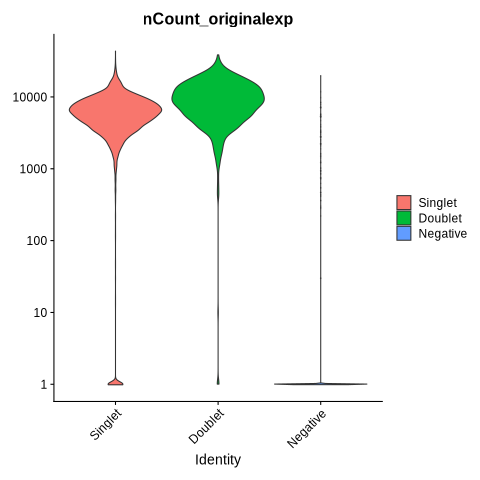

In [9]:
%%R
sobj = sobj_list[[paste0('sobj.',sample)]]
Idents(sobj) <- "HTO_globalClass"
VlnPlot(sobj, features = "nCount_originalexp", pt.size = 0, log = TRUE)

In addition: Warning messages:
1: In scale_y_log10(labels = exponent_format()) :
  log-10 transformation introduced infinite values.
2: Removed 891 rows containing missing values or values outside the scale range
(`geom_bar()`). 


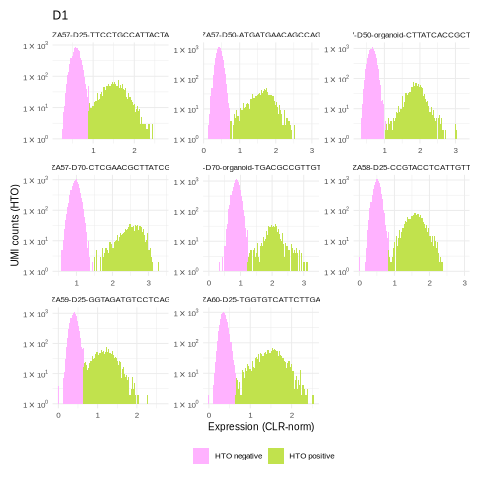

In [10]:
%%R
print(knee_plots[[paste0('plots.',sample)]])

[1] "Number of intra-doublets : 131"


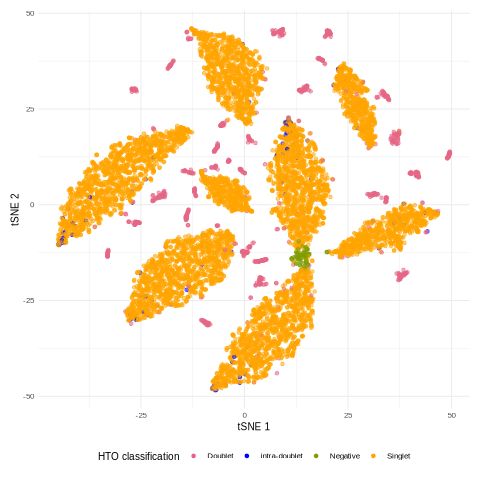

In [11]:
%%R
print(paste0('Number of intra-doublets : ',table(doublet_plot_list[[paste0('sobj.',sample)]][['HTO_globalClass']])[['intra-doublet']]))
make_plot_htotsne(doublet_plot_list[[paste0('sobj.',sample)]])

# QC and filtering

In [12]:
d1_adata = d1_adata[~d1_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
e1_adata = e1_adata[~e1_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
f1_adata = f1_adata[~f1_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
g1_adata = g1_adata[~g1_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
h1_adata = h1_adata[~h1_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
c2_adata = c2_adata[~c2_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
d2_adata = d2_adata[~d2_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
e2_adata = e2_adata[~e2_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
f2_adata = f2_adata[~f2_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
g2_adata = g2_adata[~g2_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
h2_adata = h2_adata[~h2_adata.obs['sampleID'].isin(["Doublet", "Negative"])]

a6_adata = a6_adata[~a6_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
a7_adata = a7_adata[~a7_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
a9_adata = a9_adata[~a9_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
a11_adata = a11_adata[~a11_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
b5_adata = b5_adata[~b5_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
b6_adata = b6_adata[~b6_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
b7_adata = b7_adata[~b7_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
b8_adata = b8_adata[~b8_adata.obs['sampleID'].isin(["Doublet", "Negative"])]
b10_adata = b10_adata[~b10_adata.obs['sampleID'].isin(["Doublet", "Negative"])]

d1_adata.var = d1_adata_var_meta 
e1_adata.var = e1_adata_var_meta
f1_adata.var = f1_adata_var_meta 
g1_adata.var = g1_adata_var_meta 
h1_adata.var = h1_adata_var_meta 
c2_adata.var = c2_adata_var_meta 
d2_adata.var = d2_adata_var_meta
e2_adata.var = e2_adata_var_meta
f2_adata.var = f2_adata_var_meta 
g2_adata.var = g2_adata_var_meta
h2_adata.var = h2_adata_var_meta

a6_adata.var = a6_adata_var_meta 
a7_adata.var = a7_adata_var_meta
a9_adata.var = a9_adata_var_meta 
a11_adata.var = a11_adata_var_meta 
b5_adata.var = b5_adata_var_meta 
b6_adata.var = b6_adata_var_meta 
b7_adata.var = b7_adata_var_meta
b8_adata.var = b8_adata_var_meta
b10_adata.var = b10_adata_var_meta 

In [19]:
adatas = {'D1':d1_adata, 'E1':e1_adata, 'F1':f1_adata, 'G1':g1_adata, 'H1':h1_adata, 'C2':c2_adata, 
          'D2':d2_adata, 'E2':e2_adata, 'F2':f2_adata, 'G2':g2_adata, 'H2':h2_adata,'A6':a6_adata, 
          'A7':a7_adata, 'A9':a9_adata, 'A11':a11_adata, 'B5':b5_adata, 'B6':b6_adata, 
          'B7':b7_adata, 'B8':b8_adata, 'B10':b10_adata}

for key, adata in adatas.items():

    print(key)
    adata.obs['reactionID'] = key
    
    # add reaction pattern to cell barcode
    adata.obs.index = [index + '-' + key for index in adata.obs.index]
    
    # remove th hashtag from the sample id
    adata.obs['sampleID'] = adata.obs['sampleID'].map(lambda x:x[0:x.rfind('-')])
    
    # Add diff protocol, timepoint, and condition to pandas df
    adata.obs['diff_batch'] = adata.obs['sampleID'].map(lambda x:x[0:x.find('-')]).values
    adata.obs['day'] = adata.obs['sampleID'].map(lambda x:x[x.find('-')+1:x.find('-')+4]).values
    adata.obs['condition'] = adata.obs['sampleID'].map(lambda x:x[x.rfind('-')+1:]).values
    
    # Remove ZA57 batch were patterning went wrong
    #adata = adata[adata.obs.diff_batch.isin(['ZA58','ZA59','ZA60'])].copy()
    #print(set(adata.obs.diff_batch.values))
    
    # Rename the protocols 
    protocol_dict = {'ZA58':'batch-1', 'ZA59': 'batch-2', 'ZA60': 'batch-3'}
    adata.obs['diff_batch_2'] = adata.obs['diff_batch'].map(protocol_dict)
    
    # Set the condition to control if no condition applied
    control_loc = pd.Series(list(adata[adata.obs["condition"].isin(['D25','D50','D70'])].obs.index), dtype="category")
    adata.obs["condition"].loc[control_loc] = 'CNT'
    adata.obs['condition'] = adata.obs['condition'].astype("category")
    adata.obs['condition'] = adata.obs['condition'].cat.rename_categories({'CNT':'control'})
    
    adata.obs['dimensionality'] = '2D'
    #2D vs Spheroid
    organoids = pd.Series(list(adata[adata.obs["condition"].isin(["organoid"])].obs.index), dtype="category")
    adata.obs["dimensionality"].loc[organoids] = "spheroid"
    adata.obs['condition'] = adata.obs['condition'].cat.rename_categories({'organoid':'spheroid'})
    
    
    # Remove unnecessary df from adata
    del adata.obsm
    adata.obs = adata.obs[['sampleID','reactionID','diff_batch','diff_batch_2', 'dimensionality', 'day', 'condition', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_HTO',
       'nFeature_HTO']]
    #print(adata)

D1
E1
F1
G1
H1
C2
D2
E2
F2
G2
H2
A6
A7
A9
A11
B5
B6
B7
B8
B10


In [20]:

d1_adata = d1_adata[~d1_adata.obs['diff_batch'].isin(["ZA57"])]
e1_adata = e1_adata[~e1_adata.obs['diff_batch'].isin(["ZA57"])]
f1_adata = f1_adata[~f1_adata.obs['diff_batch'].isin(["ZA57"])]
g1_adata = g1_adata[~g1_adata.obs['diff_batch'].isin(["ZA57"])]
h1_adata = h1_adata[~h1_adata.obs['diff_batch'].isin(["ZA57"])]
c2_adata = c2_adata[~c2_adata.obs['diff_batch'].isin(["ZA57"])]
d2_adata = d2_adata[~d2_adata.obs['diff_batch'].isin(["ZA57"])]
e2_adata = e2_adata[~e2_adata.obs['diff_batch'].isin(["ZA57"])]
f2_adata = f2_adata[~f2_adata.obs['diff_batch'].isin(["ZA57"])]
g2_adata = g2_adata[~g2_adata.obs['diff_batch'].isin(["ZA57"])]
h2_adata = h2_adata[~h2_adata.obs['diff_batch'].isin(["ZA57"])]

a6_adata = a6_adata[~a6_adata.obs['diff_batch'].isin(["ZA57"])]
a7_adata = a7_adata[~a7_adata.obs['diff_batch'].isin(["ZA57"])]
a9_adata = a9_adata[~a9_adata.obs['diff_batch'].isin(["ZA57"])]
a11_adata = a11_adata[~a11_adata.obs['diff_batch'].isin(["ZA57"])]
b5_adata = b5_adata[~b5_adata.obs['diff_batch'].isin(["ZA57"])]
b6_adata = b6_adata[~b6_adata.obs['diff_batch'].isin(["ZA57"])]
b7_adata = b7_adata[~b7_adata.obs['diff_batch'].isin(["ZA57"])]
b8_adata = b8_adata[~b8_adata.obs['diff_batch'].isin(["ZA57"])]
b10_adata = b10_adata[~b10_adata.obs['diff_batch'].isin(["ZA57"])]


In [26]:
adata_tmp = d1_adata.concatenate(e1_adata, f1_adata, g1_adata,h1_adata,c2_adata,d2_adata,
                                    e2_adata, f2_adata, g2_adata,h2_adata,a6_adata,a7_adata, a9_adata, a11_adata, b5_adata,
                                 b6_adata, b7_adata, b8_adata, b10_adata, batch_key=None, join='outer')

In [27]:
adata_tmp.var['ribo'] = adata_tmp.var_names.str.startswith(("RPS","RPL"))
adata_tmp.var['mt'] = adata_tmp.var_names.str.startswith('MT-') 

In [28]:
sc.pp.calculate_qc_metrics(adata_tmp, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)


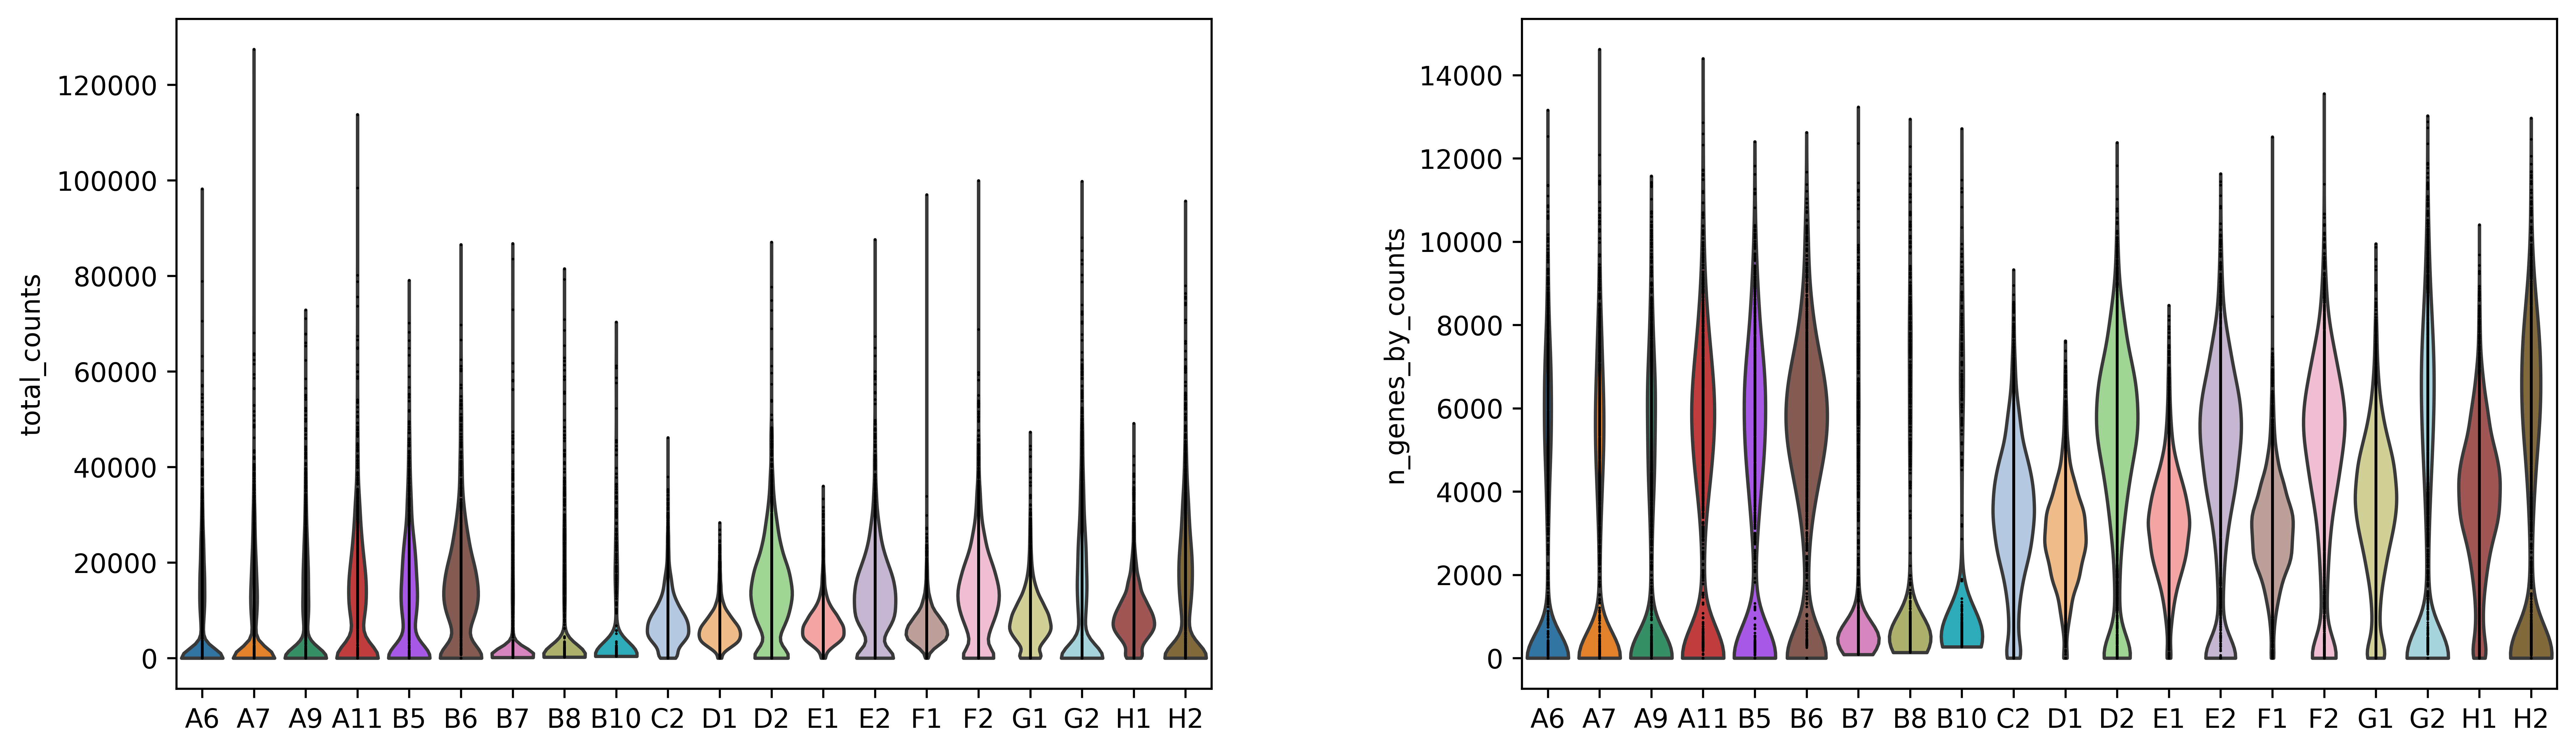

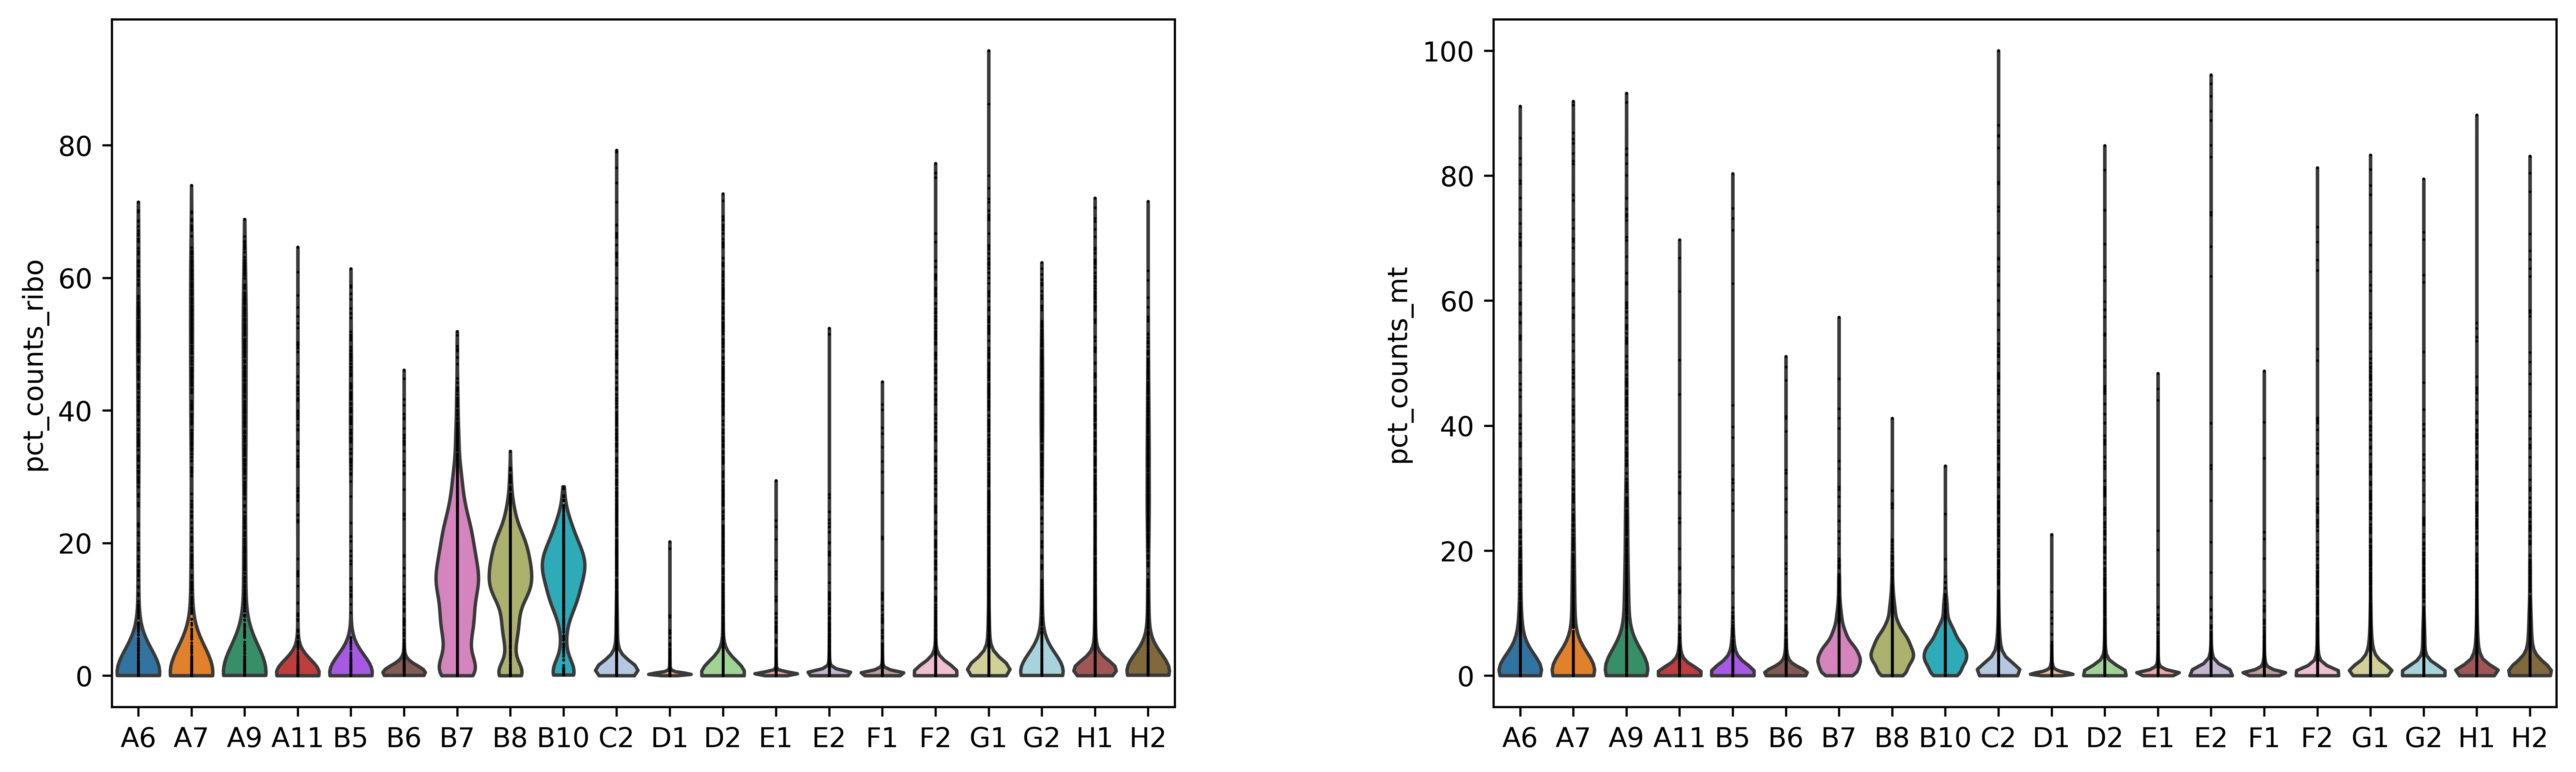

In [29]:
with plt.rc_context({ "figure.dpi": 600}):
    sc.pl.violin(adata_tmp, ['total_counts','n_genes_by_counts'],
             jitter=False, groupby = 'reactionID', rotation= 0)
    sc.pl.violin(adata_tmp, ['pct_counts_ribo', 'pct_counts_mt'],
             jitter=False, groupby = 'reactionID', rotation= 0)
    


# D1

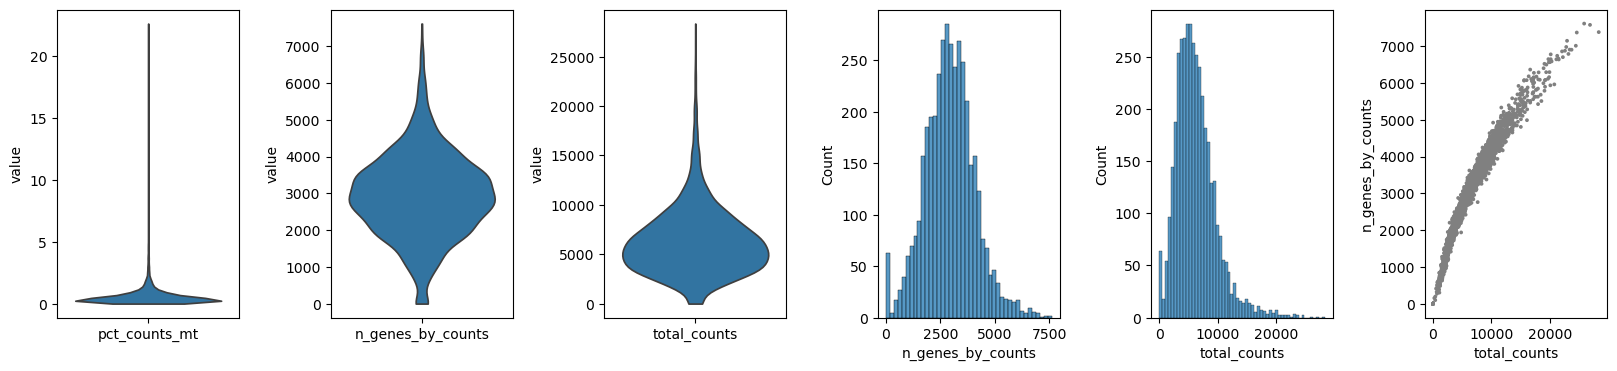

In [30]:
# Compute qc metrix
d1_adata.var['mt'] = d1_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(d1_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(d1_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(d1_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(d1_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(d1_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(d1_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(d1_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [31]:
# perform fitering
sc.pp.filter_genes(d1_adata, min_cells=3)
sc.pp.filter_cells(d1_adata, min_counts=800)
sc.pp.filter_cells(d1_adata, max_counts=19000)
sc.pp.filter_cells(d1_adata, min_genes=800)
sc.pp.filter_cells(d1_adata, max_genes=6600)
d1_adata = d1_adata[d1_adata.obs.pct_counts_mt <1.5, :] # Remove cells with high mito content

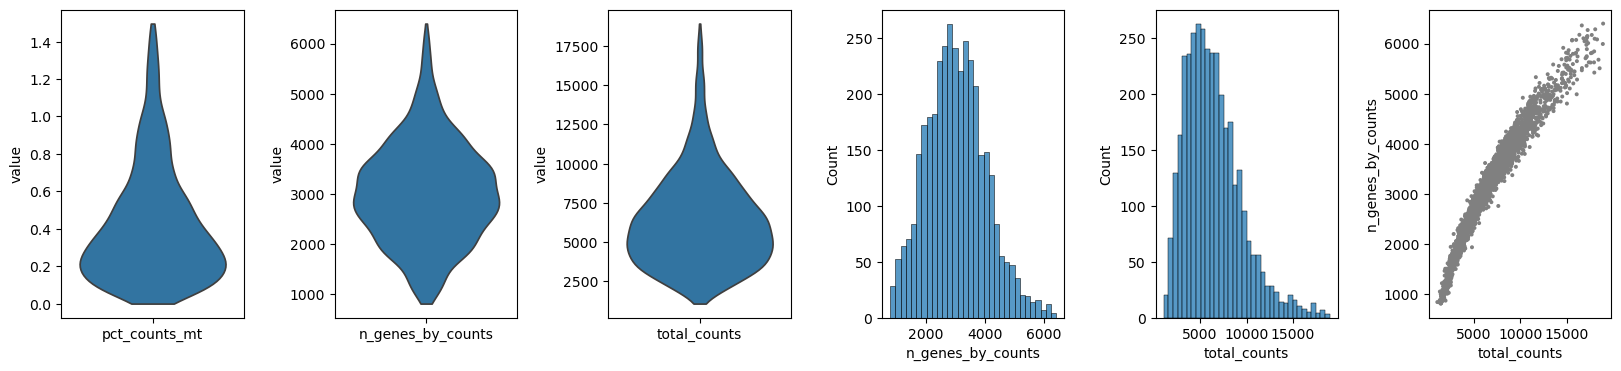

In [32]:
# Compute qc metrix
d1_adata.var['mt'] = d1_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(d1_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(d1_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(d1_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(d1_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(d1_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(d1_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(d1_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [33]:
# Remove mito and ribo genes
ribo = d1_adata.var_names.str.startswith(('RPL', "RPS"))
mito = d1_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
d1_adata = d1_adata[:,keep]

d1_adata.layers["counts"] = d1_adata.X.copy()

In [34]:
d1_adata.shape

(3639, 27851)

# E1

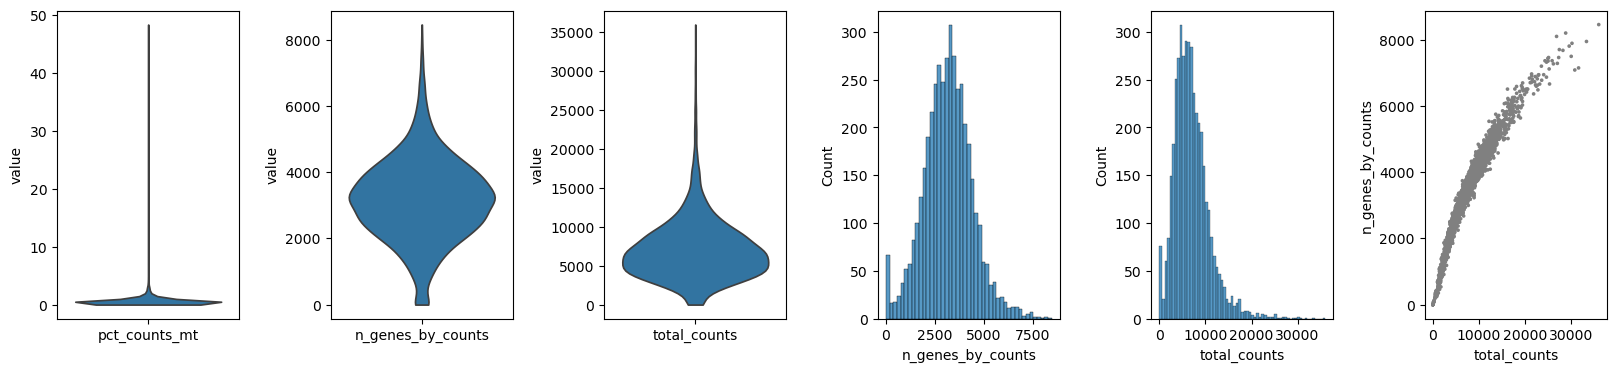

In [35]:
# Compute qc metrix
e1_adata.var['mt'] = e1_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(e1_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(e1_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(e1_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(e1_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(e1_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(e1_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(e1_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [36]:
# perform fitering
sc.pp.filter_genes(e1_adata, min_cells=3)
sc.pp.filter_cells(e1_adata, min_counts=1000)
sc.pp.filter_cells(e1_adata, max_counts=21000)
sc.pp.filter_cells(e1_adata, min_genes=800)
sc.pp.filter_cells(e1_adata, max_genes=7000)
e1_adata = e1_adata[e1_adata.obs.pct_counts_mt <1.5, :] # Remove cells with high mito content

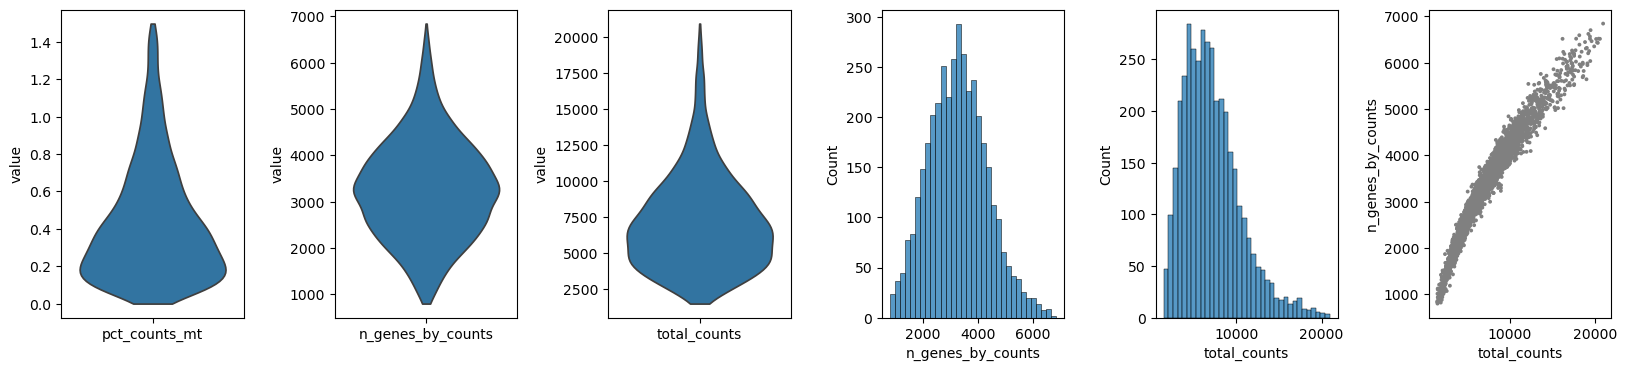

In [37]:
# Compute qc metrix
e1_adata.var['mt'] = e1_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(e1_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(e1_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(e1_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(e1_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(e1_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(e1_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(e1_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [38]:
# Remove mito and ribo genes
ribo = e1_adata.var_names.str.startswith(('RPL', "RPS"))
mito = e1_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
e1_adata = e1_adata[:,keep]

e1_adata.layers["counts"] = e1_adata.X.copy()

In [39]:
e1_adata.shape

(3905, 28332)

# F1

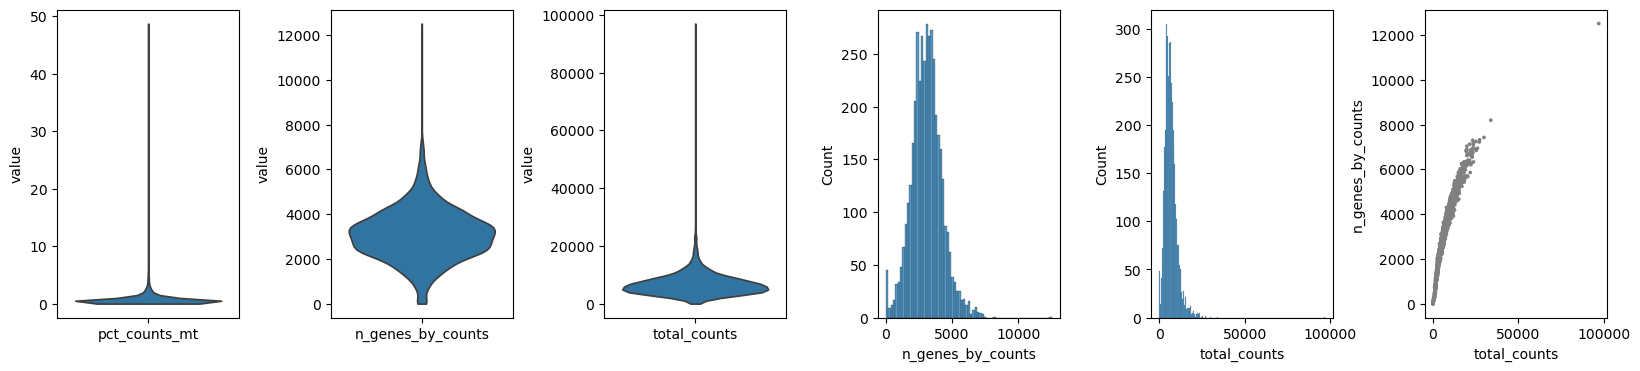

In [40]:
# Compute qc metrix
f1_adata.var['mt'] = f1_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(f1_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(f1_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(f1_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(f1_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(f1_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(f1_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(f1_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [41]:
# perform fitering
sc.pp.filter_genes(f1_adata, min_cells=3)
sc.pp.filter_cells(f1_adata, min_counts=1000)
sc.pp.filter_cells(f1_adata, max_counts=18000)
sc.pp.filter_cells(f1_adata, min_genes=800)
sc.pp.filter_cells(f1_adata, max_genes=6700)
f1_adata = f1_adata[f1_adata.obs.pct_counts_mt <1.5, :] # Remove cells with high mito content

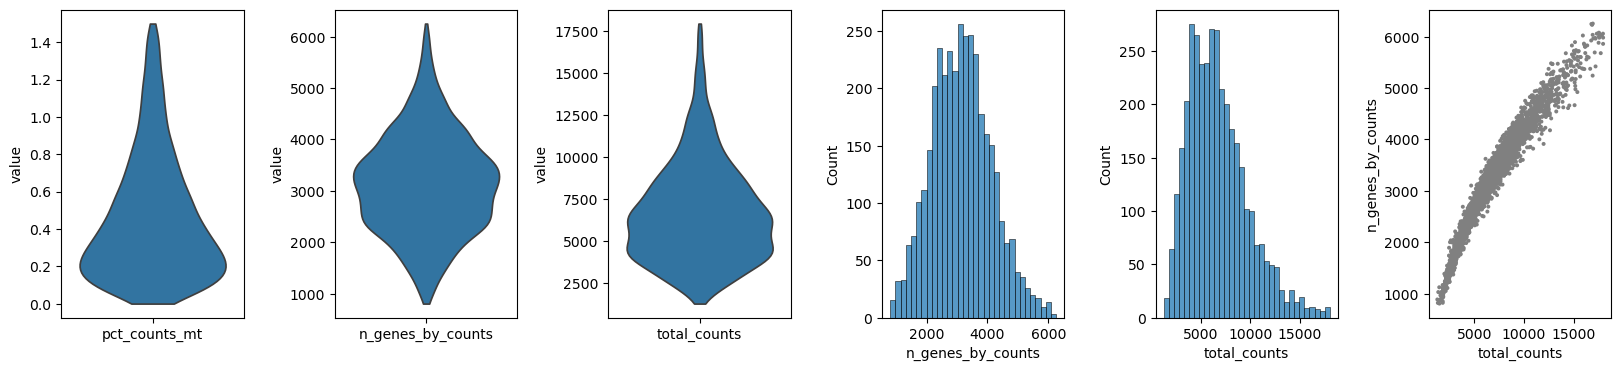

In [42]:
# Compute qc metrix
f1_adata.var['mt'] = f1_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(f1_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(f1_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(f1_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(f1_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(f1_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(f1_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(f1_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [43]:
# Remove mito and ribo genes
ribo = f1_adata.var_names.str.startswith(('RPL', "RPS"))
mito = f1_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
f1_adata = f1_adata[:,keep]

f1_adata.layers["counts"] = f1_adata.X.copy()

In [44]:
f1_adata.shape

(3646, 27993)

# G1

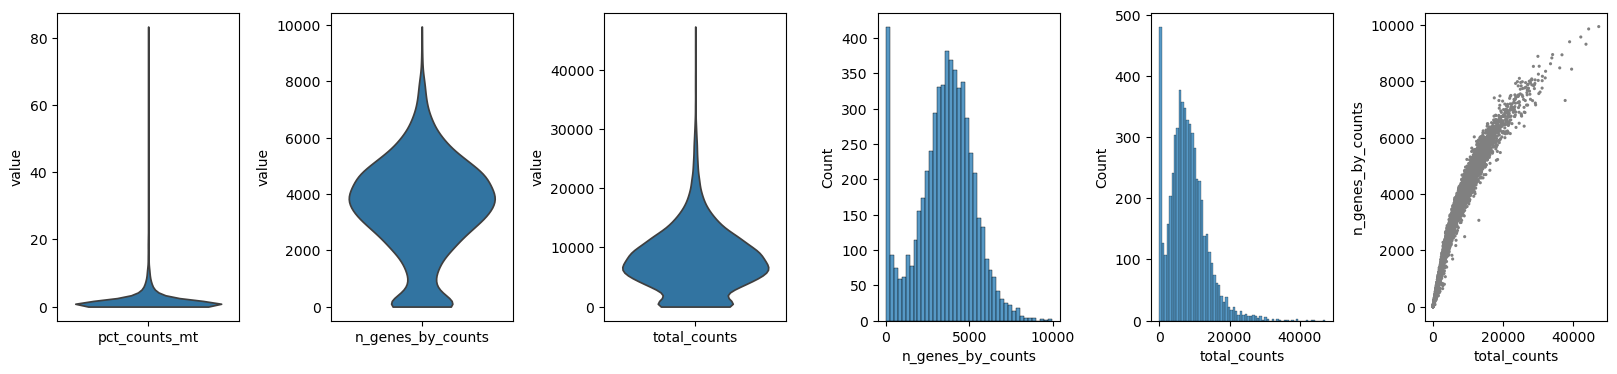

In [45]:
# Compute qc metrix
g1_adata.var['mt'] = g1_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(g1_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(g1_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(g1_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(g1_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(g1_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(g1_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(g1_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [46]:
# perform fitering
sc.pp.filter_genes(g1_adata, min_cells=3)
sc.pp.filter_cells(g1_adata, min_counts=800)
sc.pp.filter_cells(g1_adata, max_counts=25000)
sc.pp.filter_cells(g1_adata, min_genes=1100)
sc.pp.filter_cells(g1_adata, max_genes=7900)
g1_adata = g1_adata[g1_adata.obs.pct_counts_mt <3.5, :] # Remove cells with high mito content

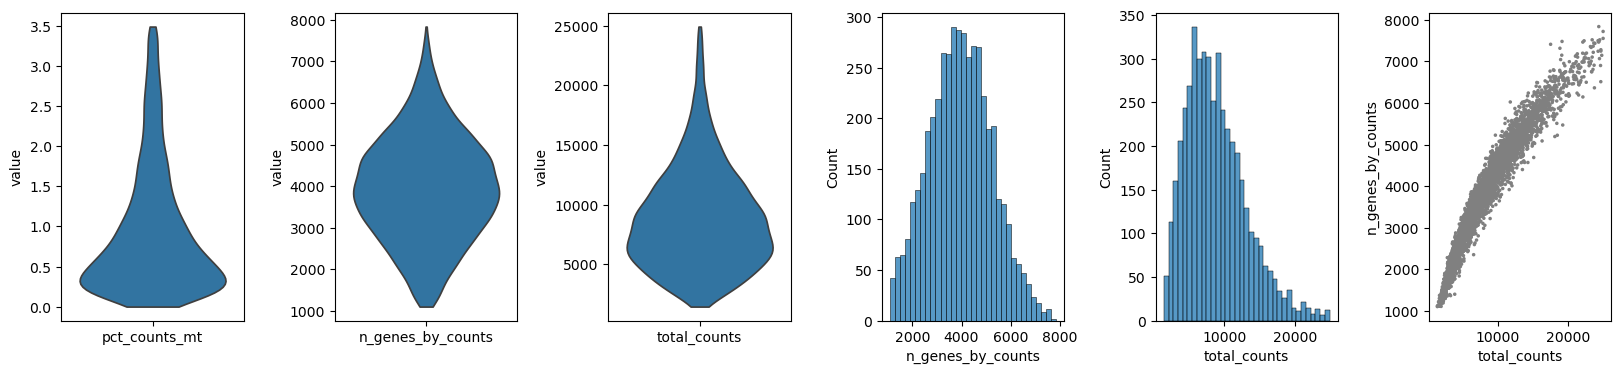

In [47]:
# Compute qc metrix
g1_adata.var['mt'] = g1_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(g1_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(g1_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(g1_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(g1_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(g1_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(g1_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(g1_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [48]:
# Remove mito and ribo genes
ribo = g1_adata.var_names.str.startswith(('RPL', "RPS"))
mito = g1_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
g1_adata = g1_adata[:,keep]

g1_adata.layers["counts"] = g1_adata.X.copy()

In [49]:
g1_adata.shape

(4637, 29839)

# H1

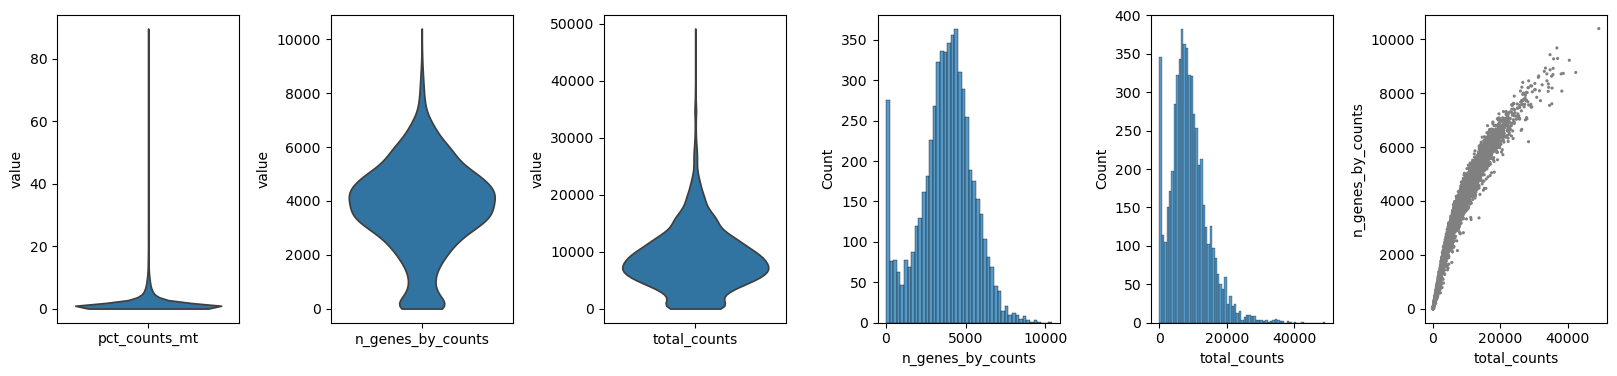

In [50]:
# Compute qc metrix
h1_adata.var['mt'] = h1_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(h1_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(h1_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(h1_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(h1_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(h1_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(h1_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(h1_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [51]:
# perform fitering
sc.pp.filter_genes(h1_adata, min_cells=3)
sc.pp.filter_cells(h1_adata, min_counts=800)
sc.pp.filter_cells(h1_adata, max_counts=26000)
sc.pp.filter_cells(h1_adata, min_genes=1100)
sc.pp.filter_cells(h1_adata, max_genes=8000)
h1_adata = h1_adata[h1_adata.obs.pct_counts_mt <3.5, :] # Remove cells with high mito content

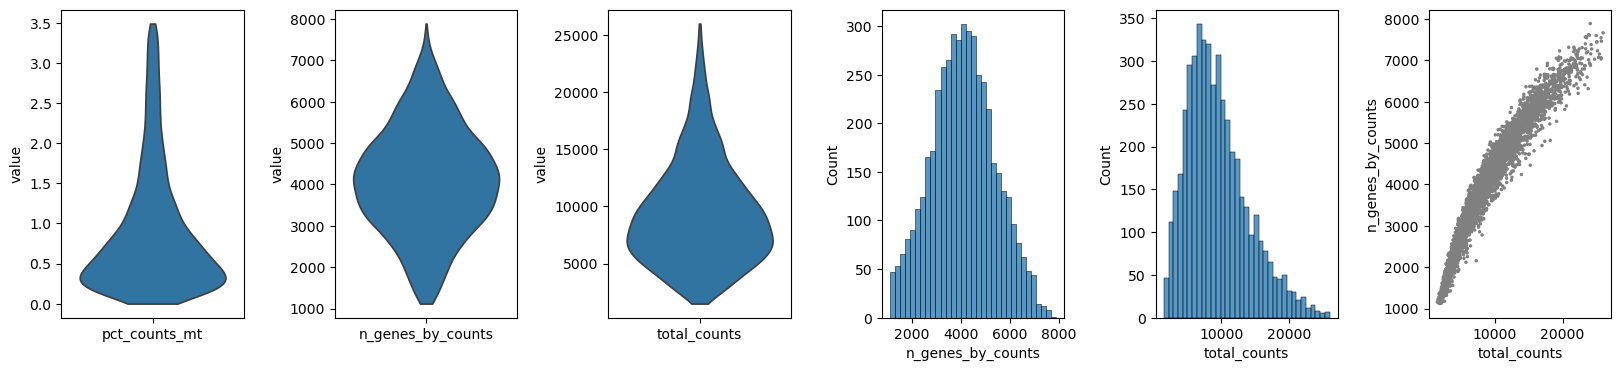

In [52]:
# Compute qc metrix
h1_adata.var['mt'] = h1_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(h1_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(h1_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(h1_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(h1_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(h1_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(h1_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(h1_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [53]:
# Remove mito and ribo genes
ribo = h1_adata.var_names.str.startswith(('RPL', "RPS"))
mito = h1_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
h1_adata = h1_adata[:,keep]

h1_adata.layers["counts"] = h1_adata.X.copy()

In [54]:
h1_adata.shape

(4763, 29952)

# C2

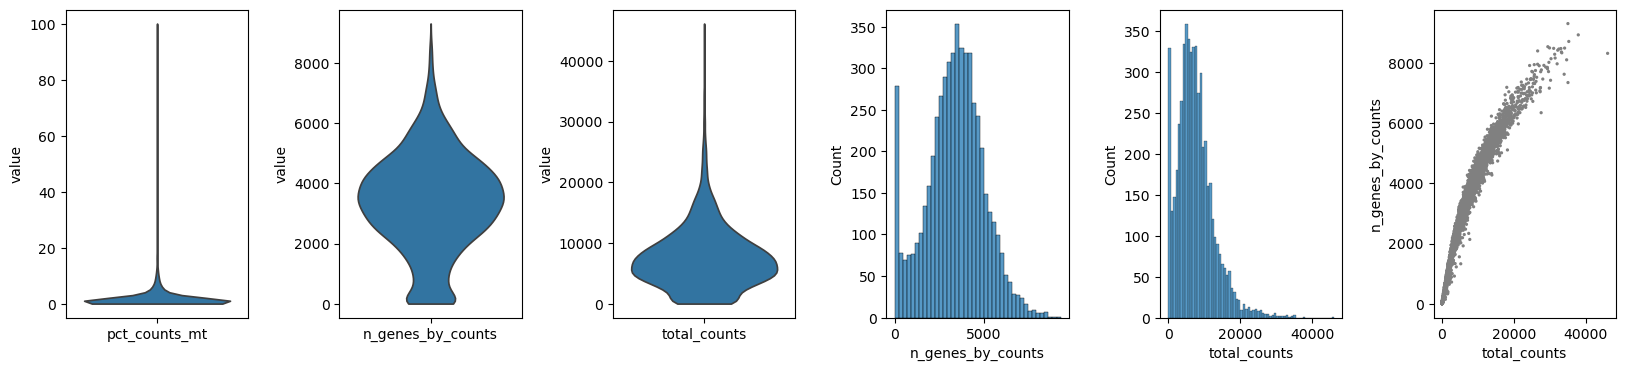

In [55]:
# Compute qc metrix
c2_adata.var['mt'] = c2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(c2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(c2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(c2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(c2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(c2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(c2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(c2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [56]:
# perform fitering
sc.pp.filter_genes(c2_adata, min_cells=3)
sc.pp.filter_cells(c2_adata, min_counts=800)
sc.pp.filter_cells(c2_adata, max_counts=21000)
sc.pp.filter_cells(c2_adata, min_genes=1100)
sc.pp.filter_cells(c2_adata, max_genes=8000)
c2_adata = c2_adata[c2_adata.obs.pct_counts_mt <3.5, :] # Remove cells with high mito content

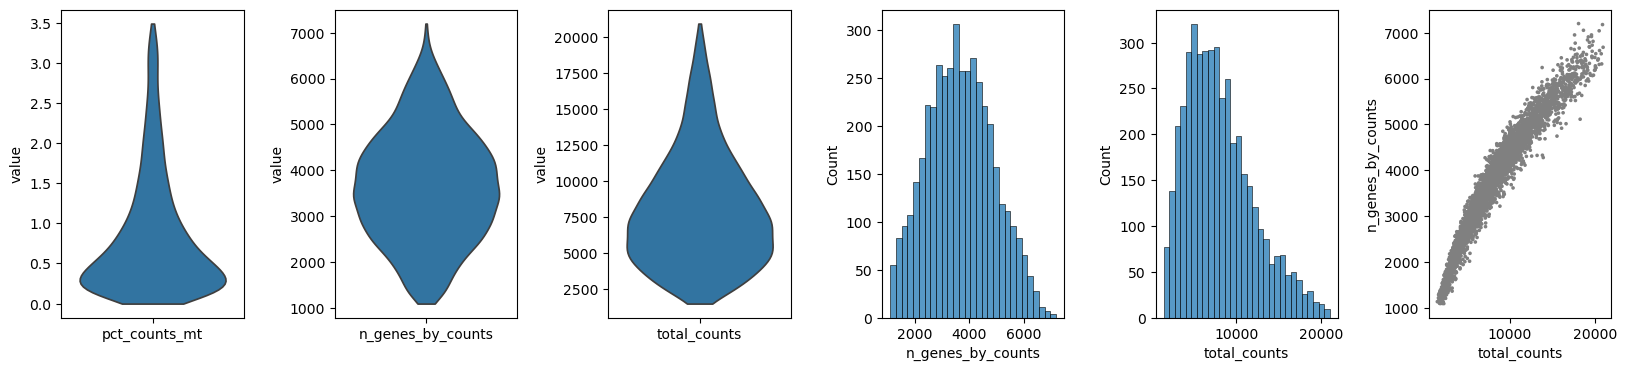

In [57]:
# Compute qc metrix
c2_adata.var['mt'] = c2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(c2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(c2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(c2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(c2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(c2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(c2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(c2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [58]:
# Remove mito and ribo genes
ribo = c2_adata.var_names.str.startswith(('RPL', "RPS"))
mito = c2_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
c2_adata = c2_adata[:,keep]

c2_adata.layers["counts"] = c2_adata.X.copy()

In [59]:
c2_adata.shape

(4348, 29453)

# D2

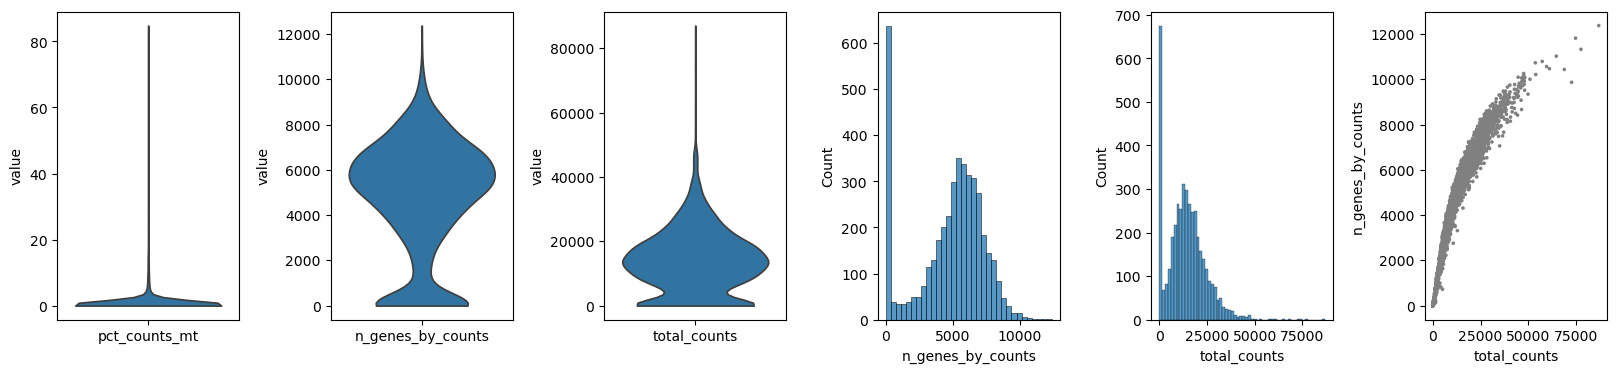

In [60]:
# Compute qc metrix
d2_adata.var['mt'] = d2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(d2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(d2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(d2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(d2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(d2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(d2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(d2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [61]:
# perform fitering
sc.pp.filter_genes(d2_adata, min_cells=3)
sc.pp.filter_cells(d2_adata, min_counts=1100)
sc.pp.filter_cells(d2_adata, max_counts=42000)
sc.pp.filter_cells(d2_adata, min_genes=2500)
sc.pp.filter_cells(d2_adata, max_genes=12000)
d2_adata = d2_adata[d2_adata.obs.pct_counts_mt <1.6, :] # Remove cells with high mito content

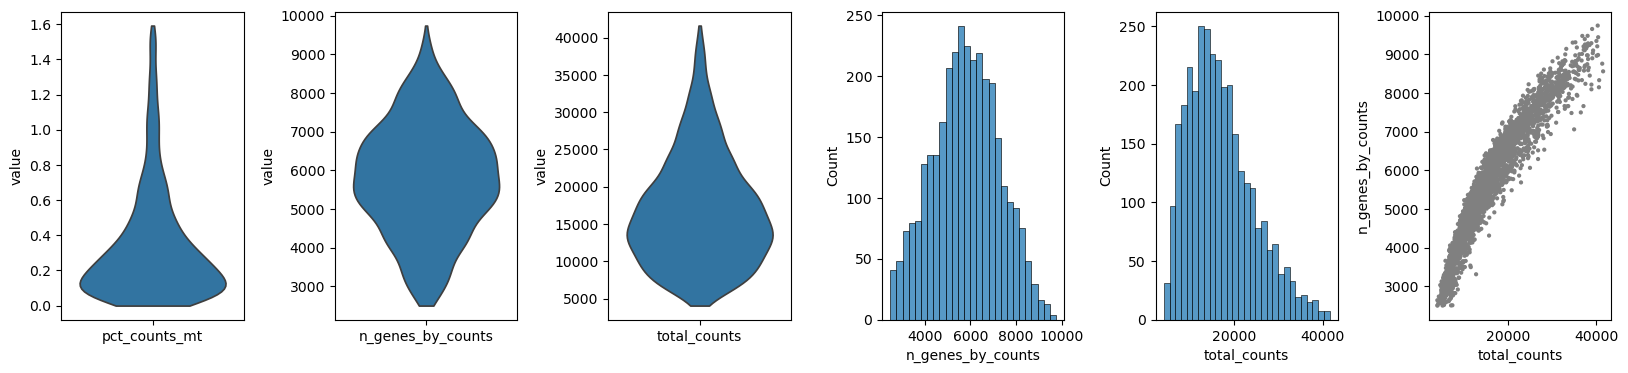

In [62]:
# Compute qc metrix
d2_adata.var['mt'] = d2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(d2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(d2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(d2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(d2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(d2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(d2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(d2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [63]:
# Remove mito and ribo genes
ribo = d2_adata.var_names.str.startswith(('RPL', "RPS"))
mito = d2_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
d2_adata = d2_adata[:,keep]

d2_adata.layers["counts"] = d2_adata.X.copy()

In [64]:
d2_adata.shape

(3232, 30565)

# E2

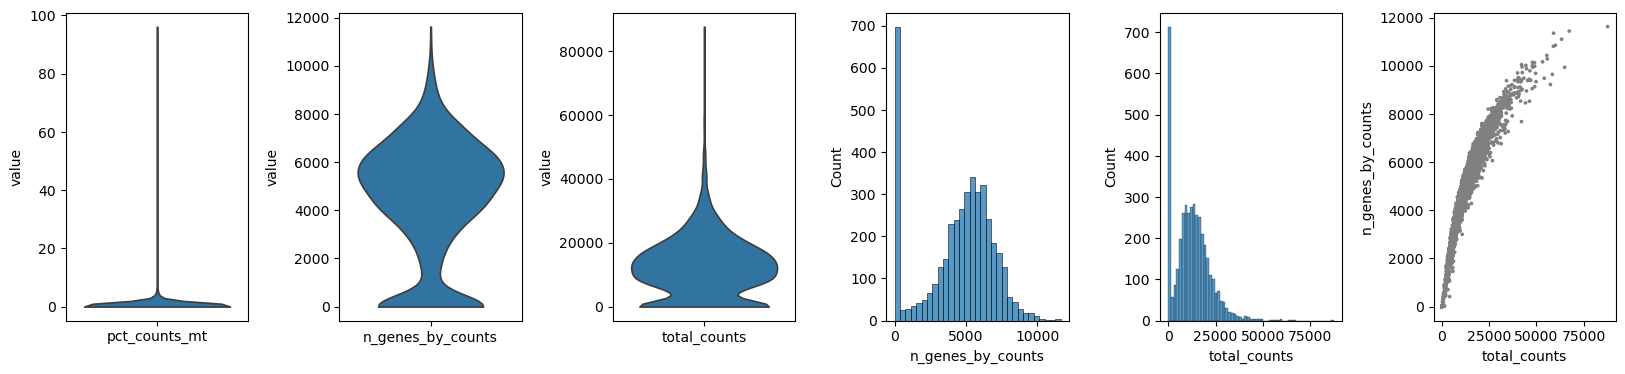

In [65]:
# Compute qc metrix
e2_adata.var['mt'] = e2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(e2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(e2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(e2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(e2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(e2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(e2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(e2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [66]:
# perform fitering
sc.pp.filter_genes(e2_adata, min_cells=3)
sc.pp.filter_cells(e2_adata, min_counts=1100)
sc.pp.filter_cells(e2_adata, max_counts=39000)
sc.pp.filter_cells(e2_adata, min_genes=2000)
sc.pp.filter_cells(e2_adata, max_genes=12000)
e2_adata = e2_adata[e2_adata.obs.pct_counts_mt <1.5, :] # Remove cells with high mito content

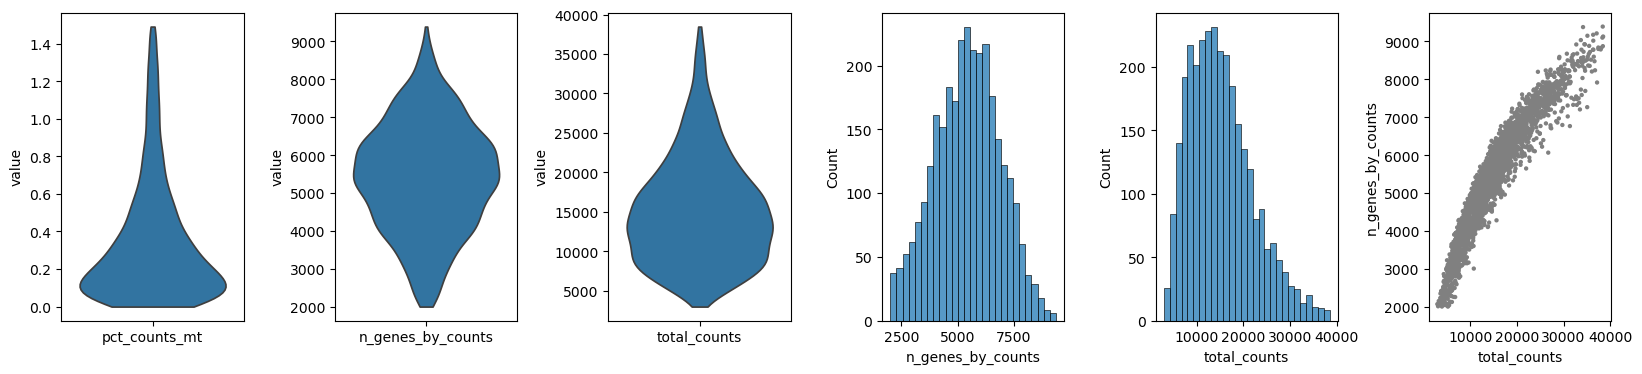

In [67]:
# Compute qc metrix
e2_adata.var['mt'] = e2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(e2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(e2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(e2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(e2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(e2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(e2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(e2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [68]:
# Remove mito and ribo genes
ribo = e2_adata.var_names.str.startswith(('RPL', "RPS"))
mito = e2_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
e2_adata = e2_adata[:,keep]

e2_adata.layers["counts"] = e2_adata.X.copy()

In [69]:
e2_adata.shape

(3041, 30282)

# F2

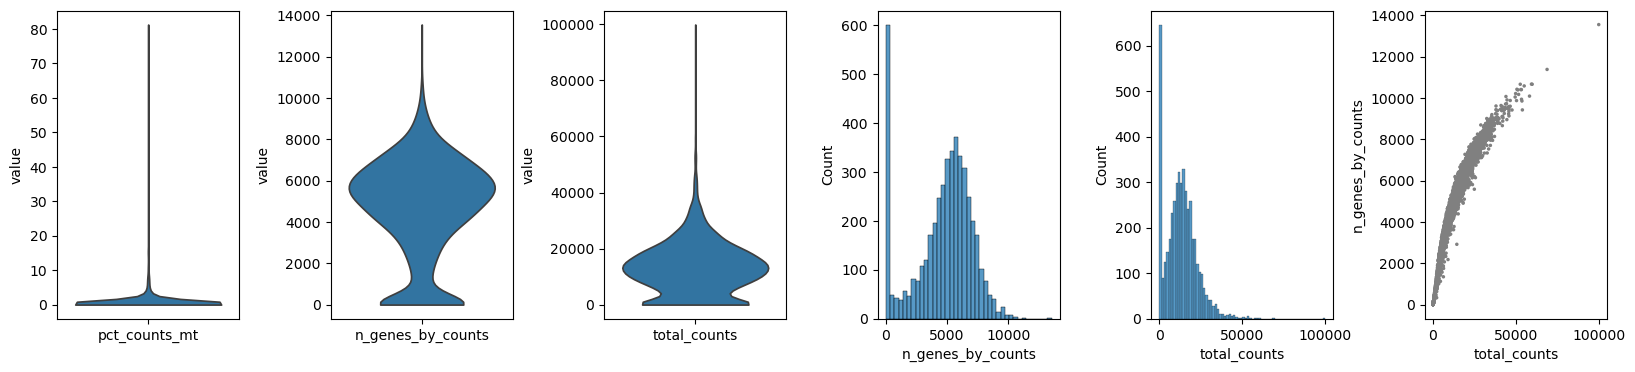

In [70]:
# Compute qc metrix
f2_adata.var['mt'] = f2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(f2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(f2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(f2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(f2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(f2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(f2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(f2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [71]:
# perform fitering
sc.pp.filter_genes(f2_adata, min_cells=3)
sc.pp.filter_cells(f2_adata, min_counts=1500)
sc.pp.filter_cells(f2_adata, max_counts=40000)
sc.pp.filter_cells(f2_adata, min_genes=1500)
sc.pp.filter_cells(f2_adata, max_genes=9600)
f2_adata = f2_adata[f2_adata.obs.pct_counts_mt <1.6, :] # Remove cells with high mito content

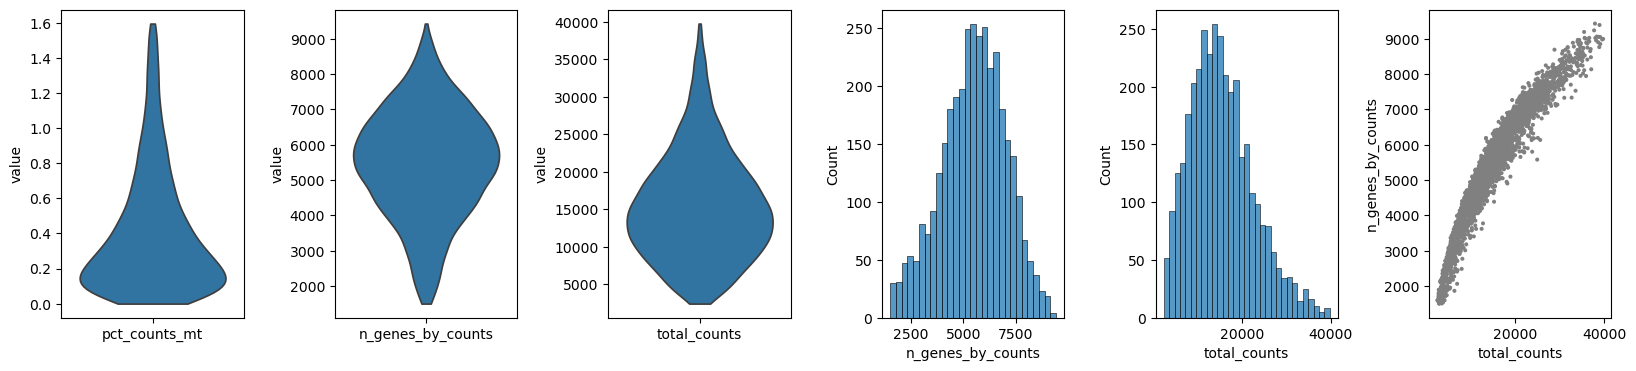

In [72]:
# Compute qc metrix
f2_adata.var['mt'] = f2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(f2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(f2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(f2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(f2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(f2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(f2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(f2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [73]:
# Remove mito and ribo genes
ribo = f2_adata.var_names.str.startswith(('RPL', "RPS"))
mito = f2_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
f2_adata = f2_adata[:,keep]

f2_adata.layers["counts"] = f2_adata.X.copy()

In [74]:
f2_adata.shape

(3514, 30519)

# G2

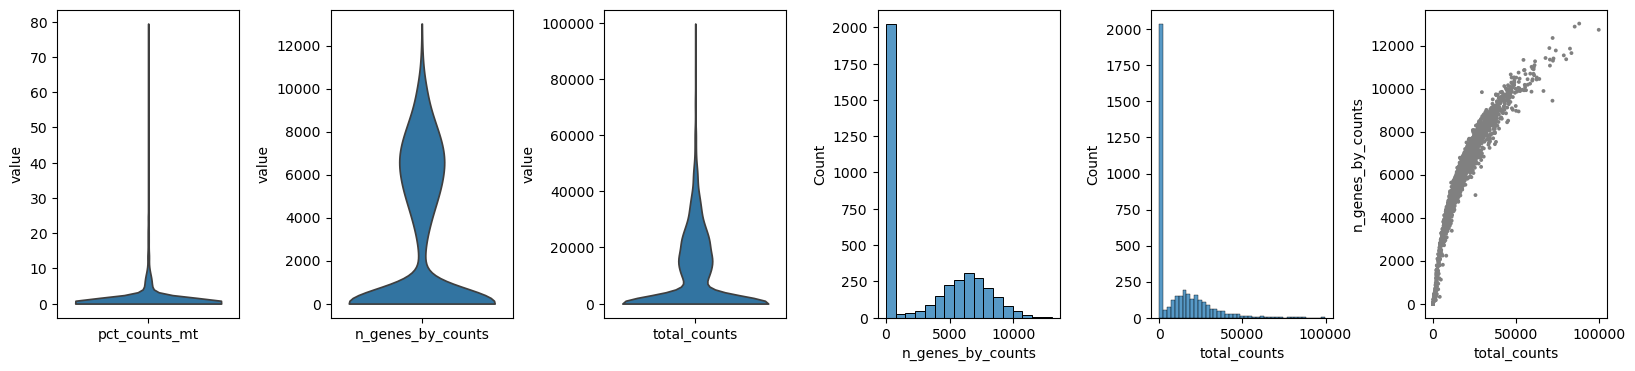

In [75]:
# Compute qc metrix
g2_adata.var['mt'] = g2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(g2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(g2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(g2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(g2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(g2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(g2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(g2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [76]:
# perform fitering
sc.pp.filter_genes(g2_adata, min_cells=3)
sc.pp.filter_cells(g2_adata, min_counts=1200)
sc.pp.filter_cells(g2_adata, max_counts=56000)
sc.pp.filter_cells(g2_adata, min_genes=1700)
sc.pp.filter_cells(g2_adata, max_genes=11000)
g2_adata = g2_adata[g2_adata.obs.pct_counts_mt <1.5, :] # Remove cells with high mito content

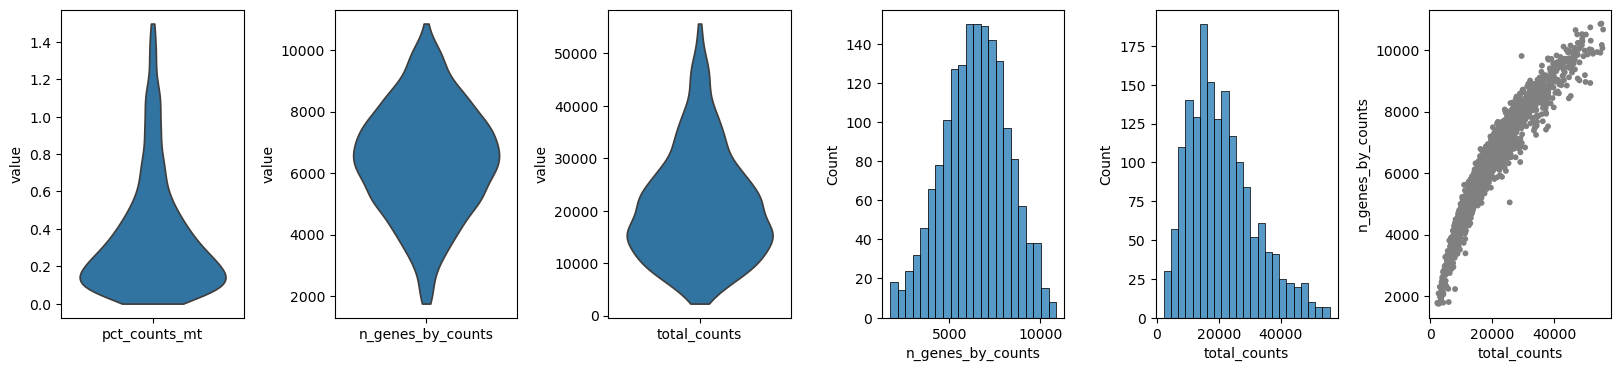

In [77]:
# Compute qc metrix
g2_adata.var['mt'] = g2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(g2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(g2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(g2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(g2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(g2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(g2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(g2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [78]:
# Remove mito and ribo genes
ribo = g2_adata.var_names.str.startswith(('RPL', "RPS"))
mito = g2_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
g2_adata = g2_adata[:,keep]

g2_adata.layers["counts"] = g2_adata.X.copy()

In [79]:
g2_adata.shape

(1691, 29962)

# H2

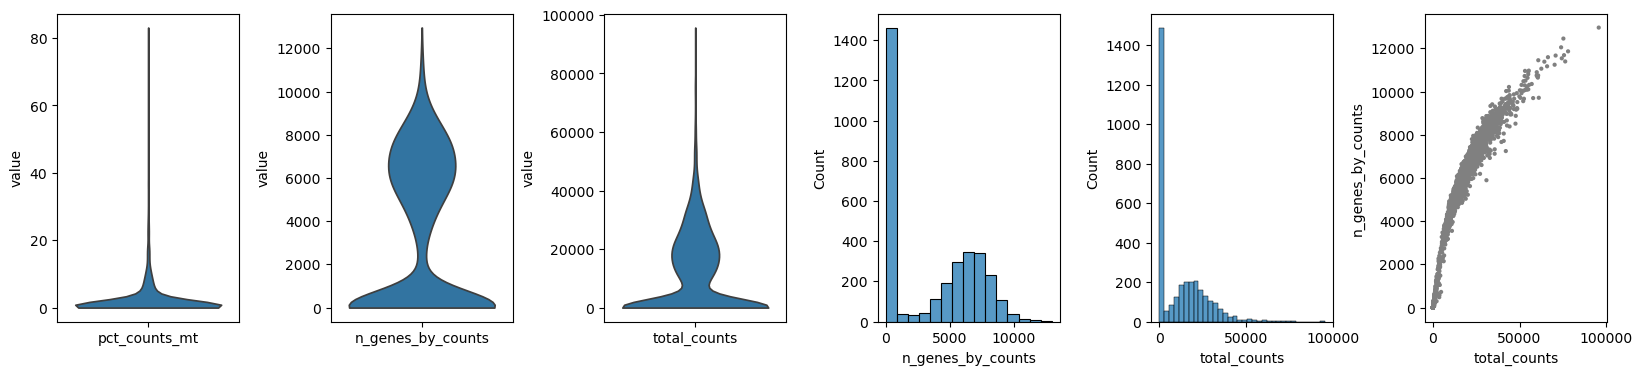

In [80]:
# Compute qc metrix
h2_adata.var['mt'] = h2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(h2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(h2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(h2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(h2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(h2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(h2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(h2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [81]:
# perform fitering
sc.pp.filter_genes(h2_adata, min_cells=3)
sc.pp.filter_cells(h2_adata, min_counts=1200)
sc.pp.filter_cells(h2_adata, max_counts=51000)
sc.pp.filter_cells(h2_adata, min_genes=2600)
sc.pp.filter_cells(h2_adata, max_genes=12000)
h2_adata = h2_adata[h2_adata.obs.pct_counts_mt <2, :] # Remove cells with high mito content

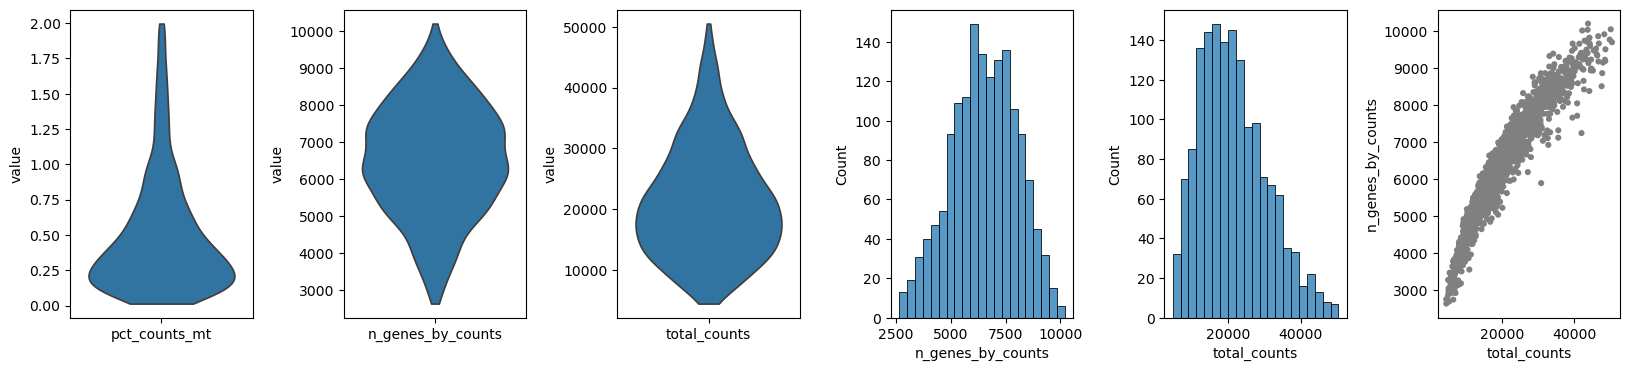

In [82]:
# Compute qc metrix
h2_adata.var['mt'] = h2_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(h2_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(h2_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(h2_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(h2_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(h2_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(h2_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(h2_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [83]:
# Remove mito and ribo genes
ribo = h2_adata.var_names.str.startswith(('RPL', "RPS"))
mito = h2_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
h2_adata = h2_adata[:,keep]

h2_adata.layers["counts"] = h2_adata.X.copy()

In [84]:
h2_adata.shape

(1557, 29651)

# A6

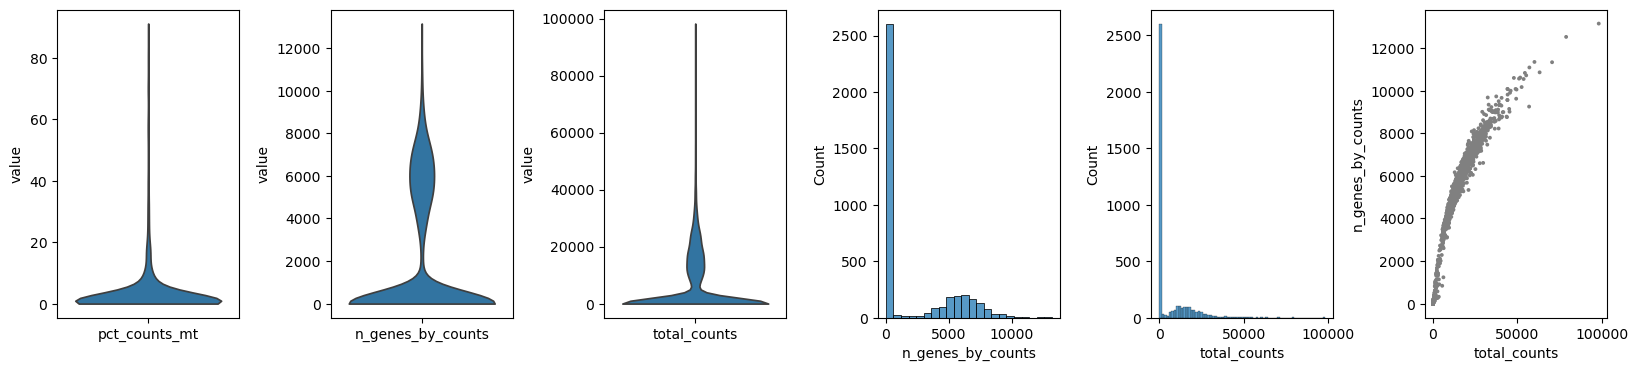

In [85]:
# Compute qc metrix
a6_adata.var['mt'] = a6_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(a6_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(a6_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(a6_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(a6_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(a6_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(a6_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(a6_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [86]:
# perform fitering
sc.pp.filter_genes(a6_adata, min_cells=3)
sc.pp.filter_cells(a6_adata, min_counts=1800)
sc.pp.filter_cells(a6_adata, max_counts=38000)
sc.pp.filter_cells(a6_adata, min_genes=2900)
sc.pp.filter_cells(a6_adata, max_genes=8800)
a6_adata = a6_adata[a6_adata.obs.pct_counts_mt <3, :] # Remove cells with high mito content

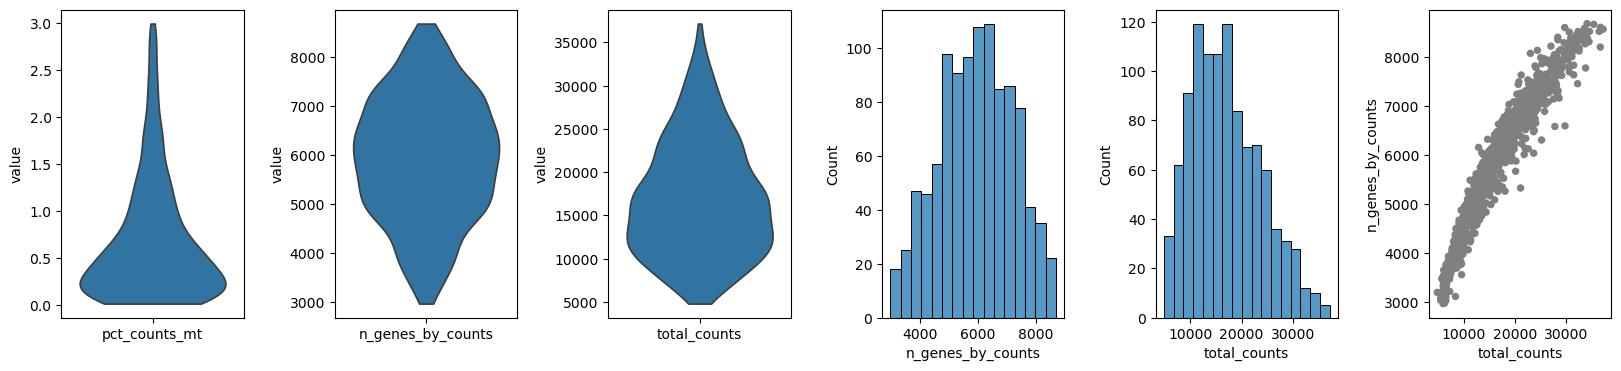

In [87]:
# Compute qc metrix
a6_adata.var['mt'] = a6_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(a6_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(a6_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(a6_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(a6_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(a6_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(a6_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(a6_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [88]:
# Remove mito and ribo genes
ribo = a6_adata.var_names.str.startswith(('RPL', "RPS"))
mito = a6_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
a6_adata = a6_adata[:,keep]

a6_adata.layers["counts"] = a6_adata.X.copy()

In [89]:
a6_adata.shape

(1043, 28906)

# A7

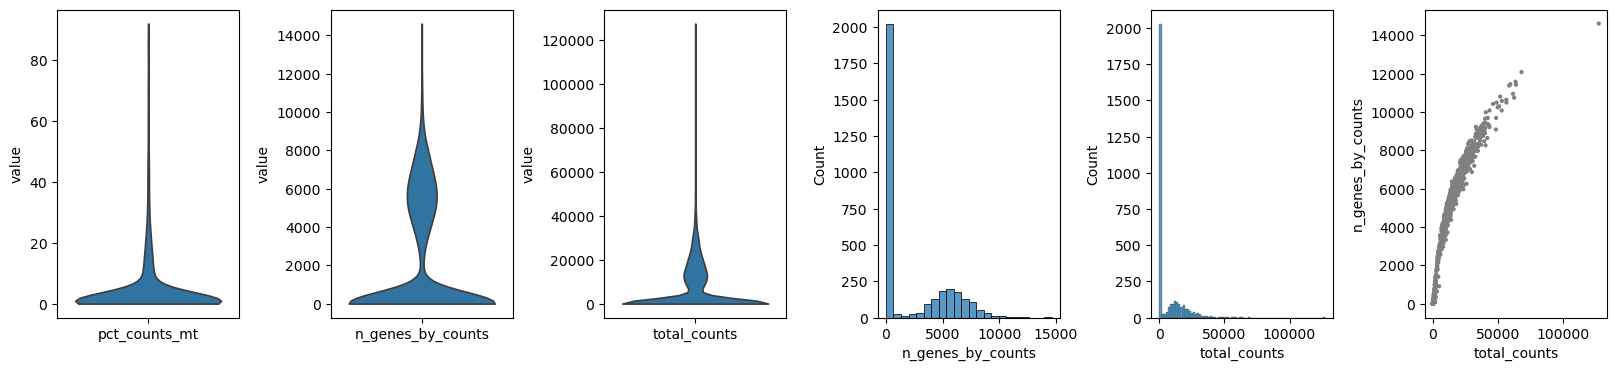

In [90]:
# Compute qc metrix
a7_adata.var['mt'] = a7_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(a7_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(a7_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(a7_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(a7_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(a7_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(a7_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(a7_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [91]:
# perform fitering
sc.pp.filter_genes(a7_adata, min_cells=3)
sc.pp.filter_cells(a7_adata, min_counts=2000)
sc.pp.filter_cells(a7_adata, max_counts=37000)
sc.pp.filter_cells(a7_adata, min_genes=2500)
sc.pp.filter_cells(a7_adata, max_genes=8800)
a7_adata = a7_adata[a7_adata.obs.pct_counts_mt <3.5, :] # Remove cells with high mito content

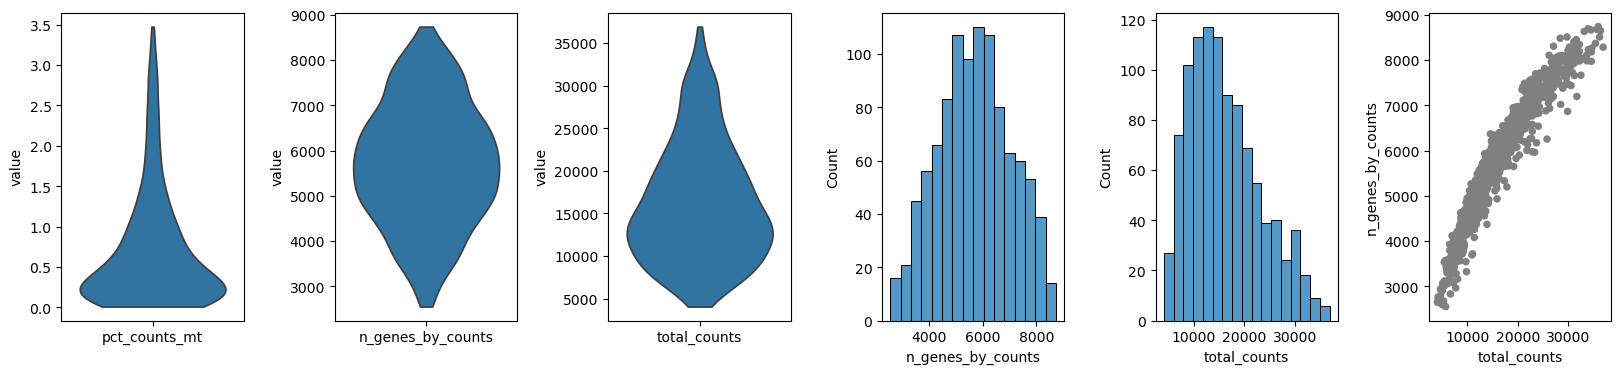

In [92]:
# Compute qc metrix
a7_adata.var['mt'] = a7_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(a7_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(a7_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(a7_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(a7_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(a7_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(a7_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(a7_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [93]:
# Remove mito and ribo genes
ribo = a7_adata.var_names.str.startswith(('RPL', "RPS"))
mito = a7_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
a7_adata = a7_adata[:,keep]

a7_adata.layers["counts"] = a7_adata.X.copy()

In [94]:
a7_adata.shape

(1018, 28555)

# A9

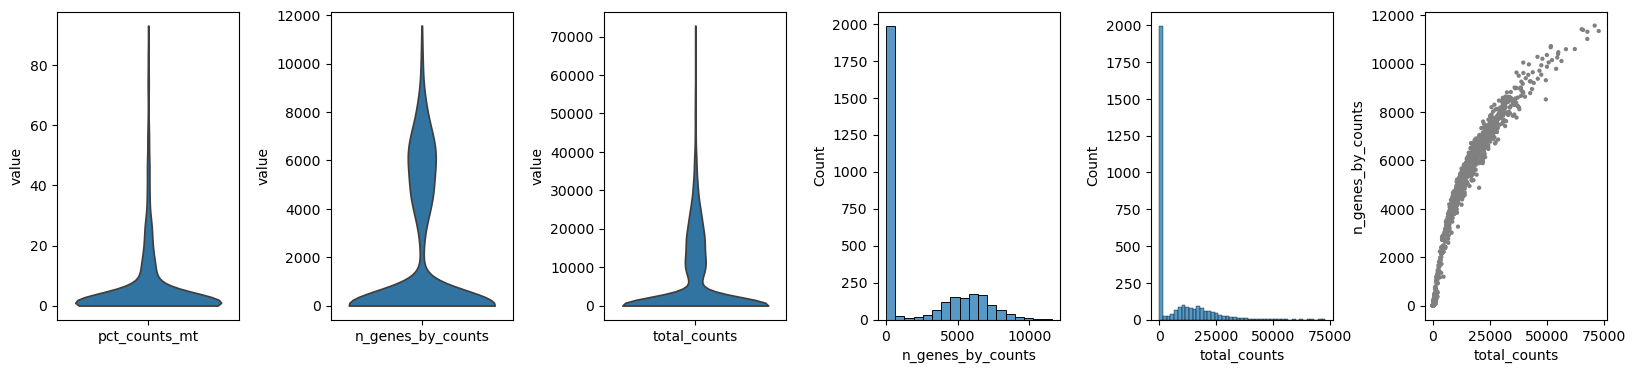

In [95]:
# Compute qc metrix
a9_adata.var['mt'] = a9_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(a9_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(a9_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(a9_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(a9_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(a9_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(a9_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(a9_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [96]:
# perform fitering
sc.pp.filter_genes(a9_adata, min_cells=3)
sc.pp.filter_cells(a9_adata, min_counts=2000)
sc.pp.filter_cells(a9_adata, max_counts=39000)
sc.pp.filter_cells(a9_adata, min_genes=2500)
sc.pp.filter_cells(a9_adata, max_genes=9100)
a9_adata = a9_adata[a9_adata.obs.pct_counts_mt <4, :] # Remove cells with high mito content

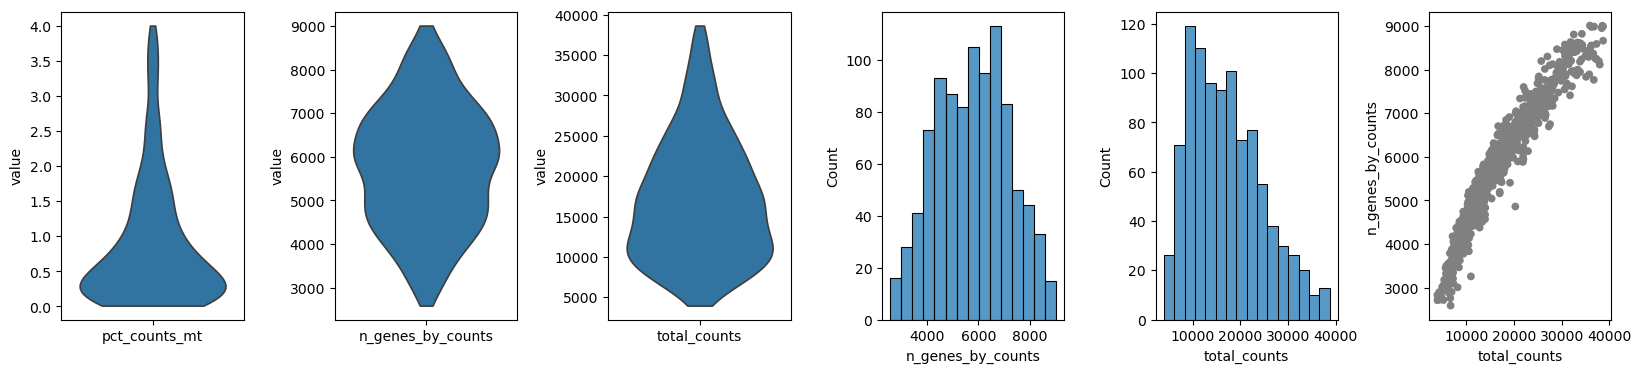

In [97]:
# Compute qc metrix
a9_adata.var['mt'] = a9_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(a9_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(a9_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(a9_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(a9_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(a9_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(a9_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(a9_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [98]:
# Remove mito and ribo genes
ribo = a9_adata.var_names.str.startswith(('RPL', "RPS"))
mito = a9_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
a9_adata = a9_adata[:,keep]

a9_adata.layers["counts"] = a9_adata.X.copy()

In [99]:
a9_adata.shape

(958, 28246)

# A11

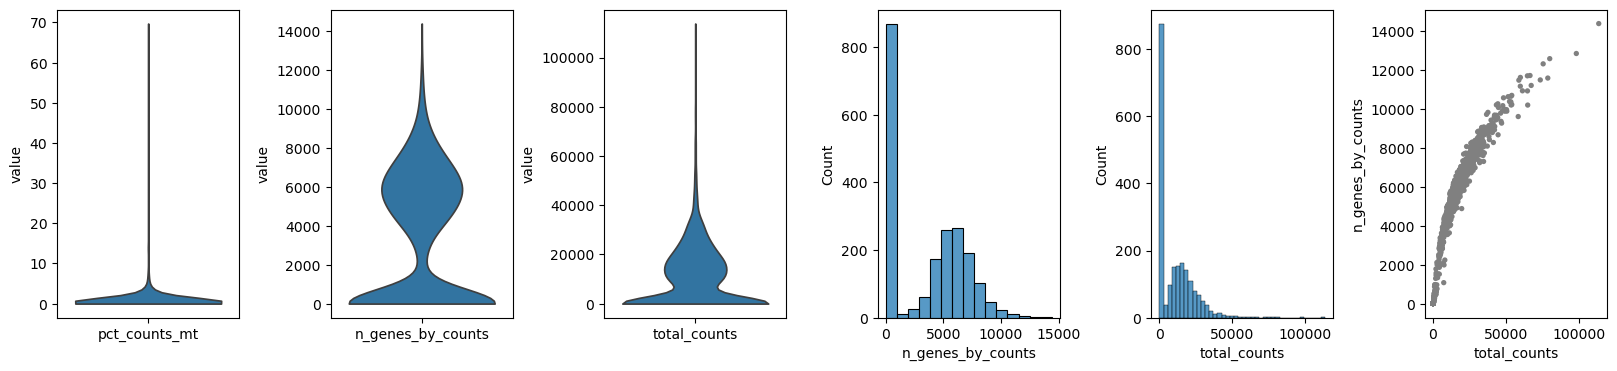

In [100]:
# Compute qc metrix
a11_adata.var['mt'] = a11_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(a11_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(a11_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(a11_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(a11_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(a11_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(a11_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(a11_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [101]:
# perform fitering
sc.pp.filter_genes(a11_adata, min_cells=3)
sc.pp.filter_cells(a11_adata, min_counts=2000)
sc.pp.filter_cells(a11_adata, max_counts=38000)
sc.pp.filter_cells(a11_adata, min_genes=2800)
sc.pp.filter_cells(a11_adata, max_genes=9500)
a11_adata = a11_adata[a11_adata.obs.pct_counts_mt <2, :] # Remove cells with high mito content

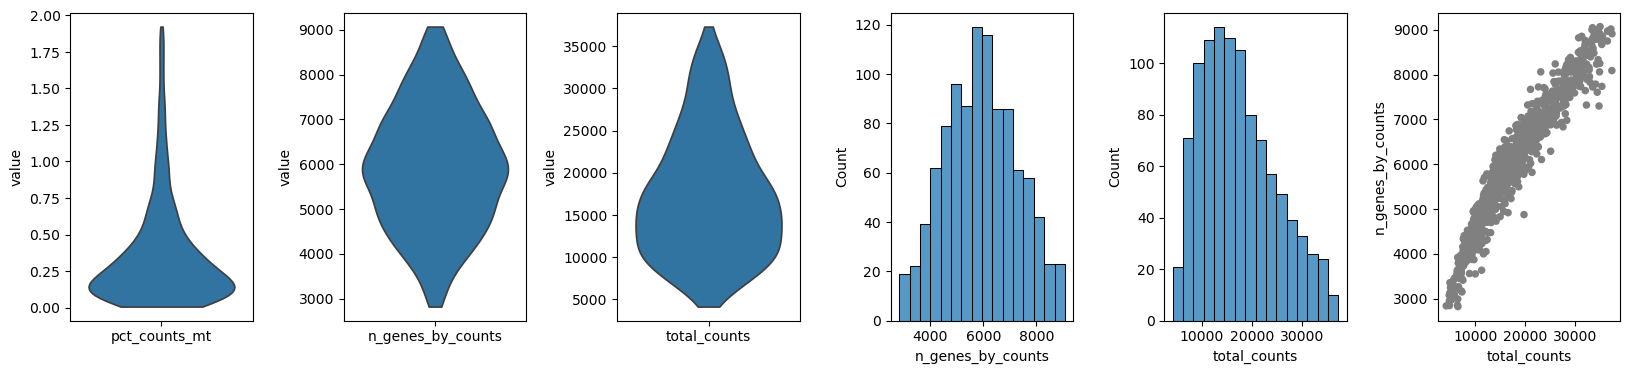

In [102]:
# Compute qc metrix
a11_adata.var['mt'] = a11_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(a11_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(a11_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(a11_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(a11_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(a11_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(a11_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(a11_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [103]:
# Remove mito and ribo genes
ribo = a11_adata.var_names.str.startswith(('RPL', "RPS"))
mito = a11_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
a11_adata = a11_adata[:,keep]

a11_adata.layers["counts"] = a11_adata.X.copy()

In [104]:
a11_adata.shape

(1018, 28206)

# B5

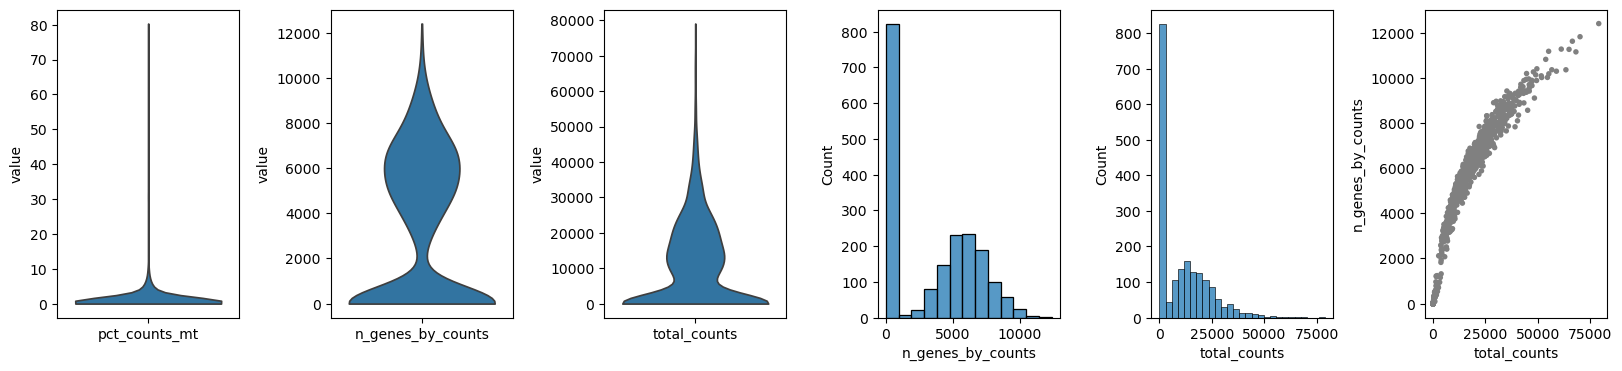

In [105]:
# Compute qc metrix
b5_adata.var['mt'] = b5_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(b5_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(b5_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(b5_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(b5_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(b5_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(b5_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(b5_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [106]:
# perform fitering
sc.pp.filter_genes(b5_adata, min_cells=3)
sc.pp.filter_cells(b5_adata, min_counts=2000)
sc.pp.filter_cells(b5_adata, max_counts=40000)
sc.pp.filter_cells(b5_adata, min_genes=2550)
sc.pp.filter_cells(b5_adata, max_genes=12000)
b5_adata = b5_adata[b5_adata.obs.pct_counts_mt <2, :] # Remove cells with high mito content

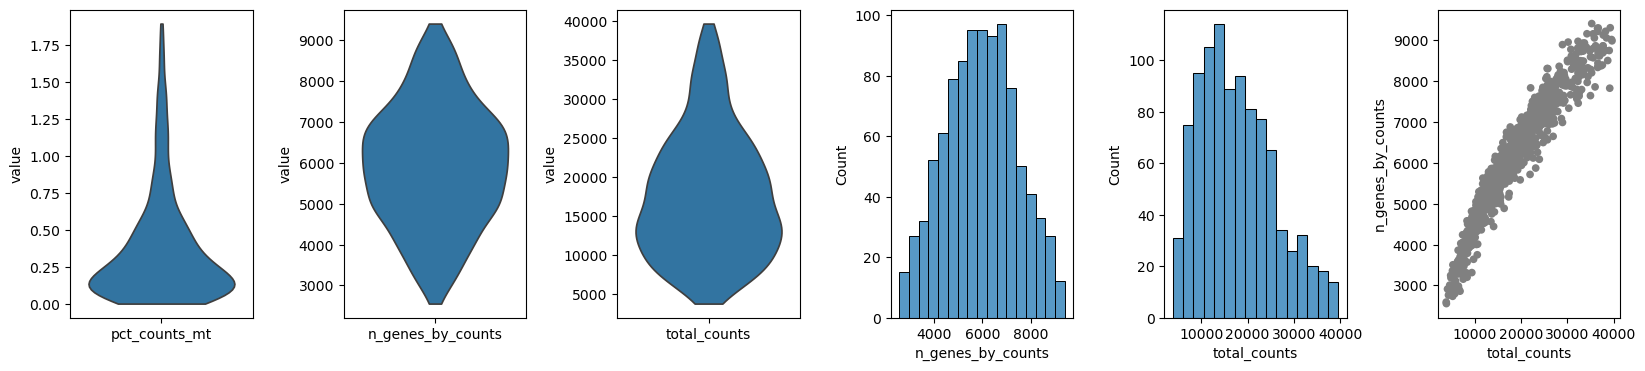

In [107]:
# Compute qc metrix
b5_adata.var['mt'] = b5_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(b5_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(b5_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(b5_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(b5_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(b5_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(b5_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(b5_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [108]:
# Remove mito and ribo genes
ribo = b5_adata.var_names.str.startswith(('RPL', "RPS"))
mito = b5_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
b5_adata = b5_adata[:,keep]

b5_adata.layers["counts"] = b5_adata.X.copy()

In [109]:
b5_adata.shape

(970, 28089)

# B6

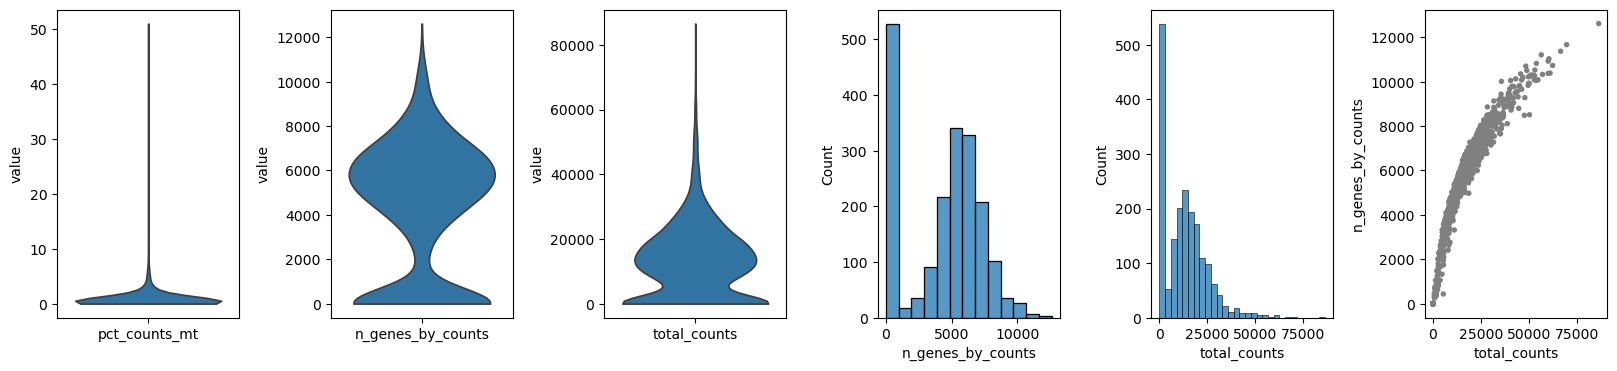

In [110]:
# Compute qc metrix
b6_adata.var['mt'] = b6_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(b6_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(b6_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(b6_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(b6_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(b6_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(b6_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(b6_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [111]:
# perform fitering
sc.pp.filter_genes(b6_adata, min_cells=3)
sc.pp.filter_cells(b6_adata, min_counts=2000)
sc.pp.filter_cells(b6_adata, max_counts=36000)
sc.pp.filter_cells(b6_adata, min_genes=2800)
sc.pp.filter_cells(b6_adata, max_genes=8800)
b6_adata = b6_adata[b6_adata.obs.pct_counts_mt <2, :] # Remove cells with high mito content

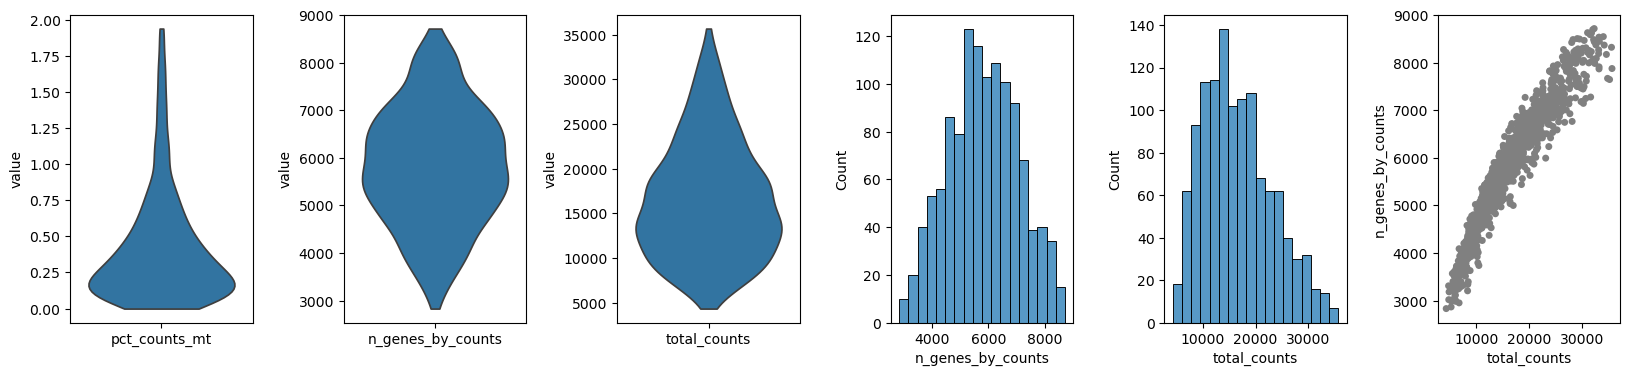

In [112]:
# Compute qc metrix
b6_adata.var['mt'] = b6_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(b6_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(b6_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(b6_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(b6_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(b6_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(b6_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(b6_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [113]:
# Remove mito and ribo genes
ribo = b6_adata.var_names.str.startswith(('RPL', "RPS"))
mito = b6_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
b6_adata = b6_adata[:,keep]

b6_adata.layers["counts"] = b6_adata.X.copy()

In [114]:
b6_adata.shape

(1184, 28337)

# B7

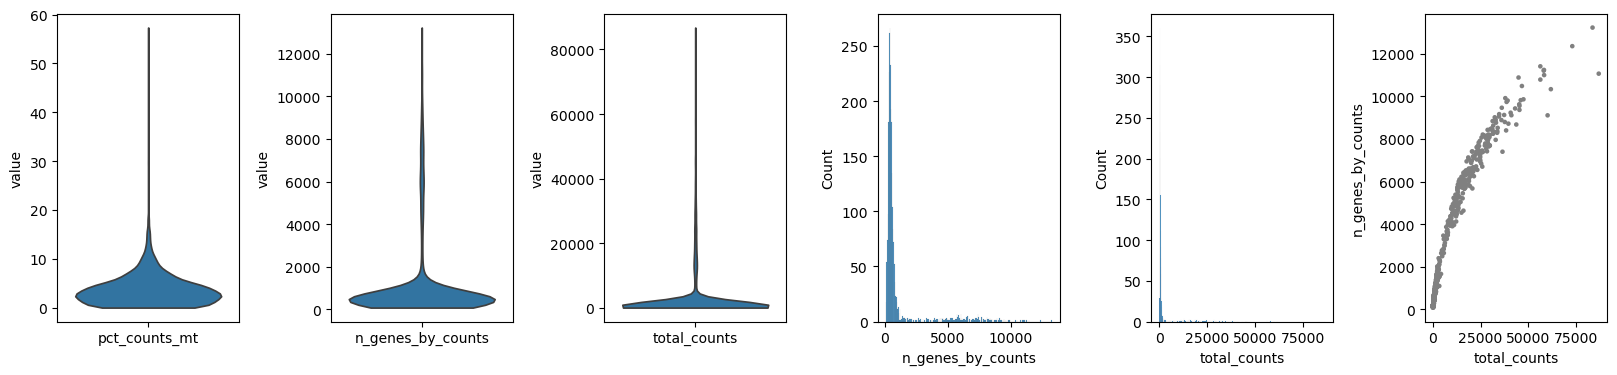

In [115]:
# Compute qc metrix
b7_adata.var['mt'] = b7_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(b7_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(b7_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(b7_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(b7_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(b7_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(b7_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(b7_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [116]:
# perform fitering
sc.pp.filter_genes(b7_adata, min_cells=3)
sc.pp.filter_cells(b7_adata, min_counts=1600)
sc.pp.filter_cells(b7_adata, max_counts=43000)
sc.pp.filter_cells(b7_adata, min_genes=2100)
sc.pp.filter_cells(b7_adata, max_genes=12000)
b7_adata = b7_adata[b7_adata.obs.pct_counts_mt <1, :] # Remove cells with high mito content

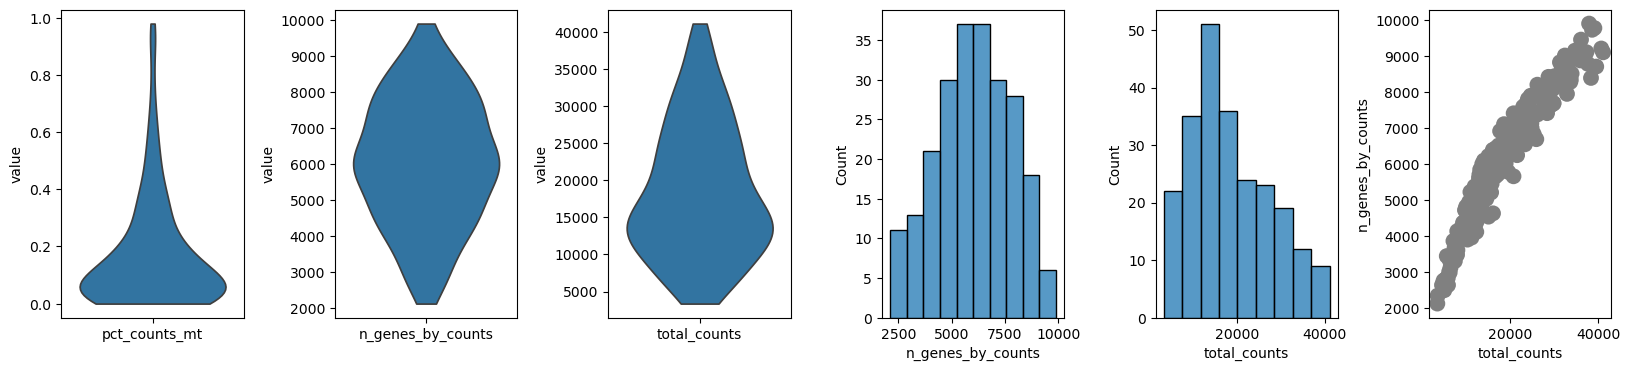

In [117]:
# Compute qc metrix
b7_adata.var['mt'] = b7_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(b7_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(b7_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(b7_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(b7_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(b7_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(b7_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(b7_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [118]:
# Remove mito and ribo genes
ribo = b7_adata.var_names.str.startswith(('RPL', "RPS"))
mito = b7_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
b7_adata = b7_adata[:,keep]

b7_adata.layers["counts"] = b7_adata.X.copy()

In [119]:
b7_adata.shape

(231, 27303)

# b8

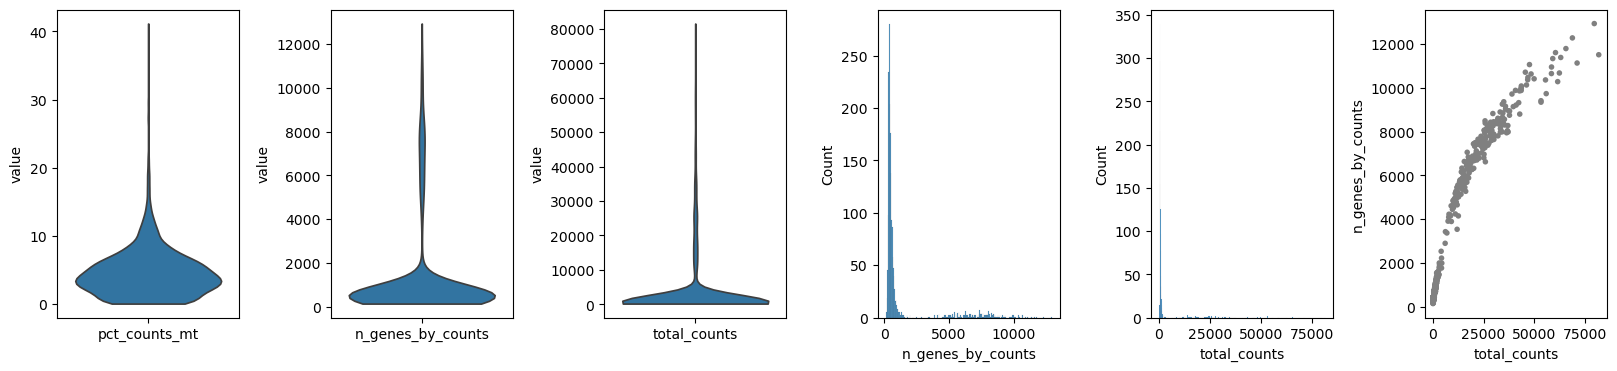

In [120]:
# Compute qc metrix
b8_adata.var['mt'] = b8_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(b8_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(b8_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(b8_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(b8_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(b8_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(b8_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(b8_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [121]:
# perform fitering
sc.pp.filter_genes(b8_adata, min_cells=3)
sc.pp.filter_cells(b8_adata, min_counts=1000)
sc.pp.filter_cells(b8_adata, max_counts=45000)
sc.pp.filter_cells(b8_adata, min_genes=3000)
sc.pp.filter_cells(b8_adata, max_genes=10000)
b8_adata = b8_adata[b8_adata.obs.pct_counts_mt <1.7, :] # Remove cells with high mito content

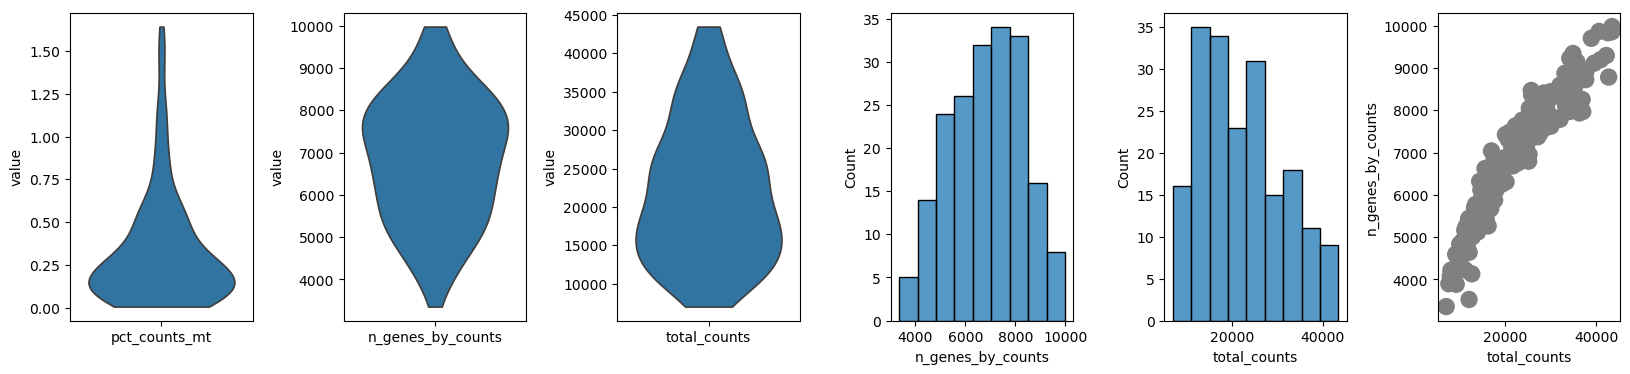

In [122]:
# Compute qc metrix
b8_adata.var['mt'] = b8_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(b8_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(b8_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(b8_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(b8_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(b8_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(b8_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(b8_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [123]:
# Remove mito and ribo genes
ribo = b8_adata.var_names.str.startswith(('RPL', "RPS"))
mito = b8_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
b8_adata = b8_adata[:,keep]

b8_adata.layers["counts"] = b8_adata.X.copy()

In [124]:
b8_adata.shape

(192, 26378)

# B10

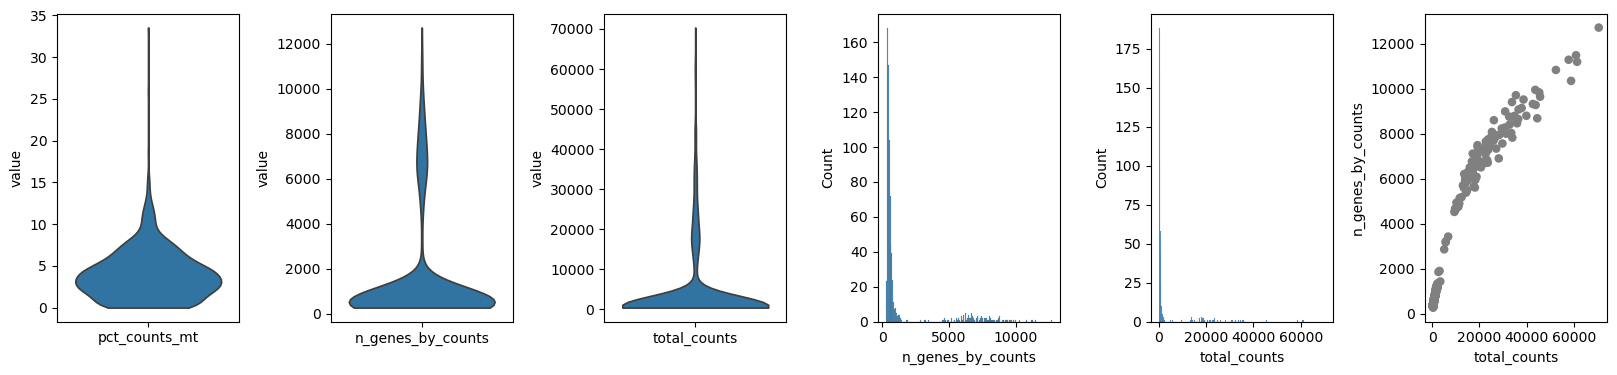

In [125]:
# Compute qc metrix
b10_adata.var['mt'] = b10_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(b10_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(b10_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(b10_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(b10_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(b10_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(b10_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(b10_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [126]:
# perform fitering
sc.pp.filter_genes(b10_adata, min_cells=3)
sc.pp.filter_cells(b10_adata, min_counts=1000)
sc.pp.filter_cells(b10_adata, max_counts=43000)
sc.pp.filter_cells(b10_adata, min_genes=4000)
sc.pp.filter_cells(b10_adata, max_genes=12000)
b10_adata = b10_adata[b10_adata.obs.pct_counts_mt <1, :] # Remove cells with high mito content

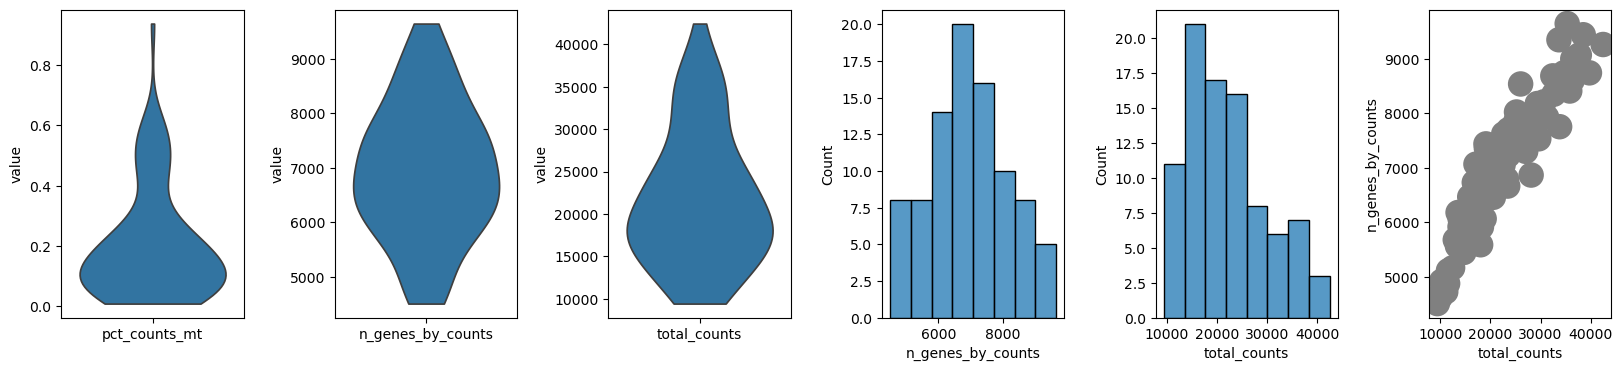

In [127]:
# Compute qc metrix
b10_adata.var['mt'] = b10_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(b10_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6,  figsize=(20,4), gridspec_kw={'wspace':0.5})
ax0_dict = sc.pl.violin(b10_adata,["pct_counts_mt"], jitter=0.5, show=False, ax=ax0, stripplot=False)
ax1_dict = sc.pl.violin(b10_adata,['n_genes_by_counts'], jitter=0.5, show=False, ax = ax1, stripplot=False) 
ax2_dict = sc.pl.violin(b10_adata,['total_counts'], jitter=0.5, show=False, ax = ax2, stripplot=False)
ax3_dict = sns.histplot(b10_adata.obs["n_genes_by_counts"],  ax = ax3)
ax4_dict = sns.histplot(b10_adata.obs["total_counts"], ax = ax4)
ax5_dict = sc.pl.scatter(b10_adata, x='total_counts', y='n_genes_by_counts', show=False, ax=ax5)

In [128]:
# Remove mito and ribo genes
ribo = b10_adata.var_names.str.startswith(('RPL', "RPS"))
mito = b10_adata.var_names.str.startswith('MT-')
remove = np.add(mito, ribo)
keep = np.invert(remove)
b10_adata = b10_adata[:,keep]

b10_adata.layers["counts"] = b10_adata.X.copy()

In [129]:
b10_adata.shape

(89, 23800)

# Normalize and concatenate data

In [130]:
sc.pp.normalize_total(d1_adata, target_sum=1e4)
sc.pp.log1p(d1_adata)

sc.pp.normalize_total(e1_adata, target_sum=1e4)
sc.pp.log1p(e1_adata)

sc.pp.normalize_total(f1_adata, target_sum=1e4)
sc.pp.log1p(f1_adata)

sc.pp.normalize_total(g1_adata, target_sum=1e4)
sc.pp.log1p(g1_adata)

sc.pp.normalize_total(h1_adata, target_sum=1e4)
sc.pp.log1p(h1_adata)

sc.pp.normalize_total(c2_adata, target_sum=1e4)
sc.pp.log1p(c2_adata)

sc.pp.normalize_total(d2_adata, target_sum=1e4)
sc.pp.log1p(d2_adata)

sc.pp.normalize_total(e2_adata, target_sum=1e4)
sc.pp.log1p(e2_adata)

sc.pp.normalize_total(f2_adata, target_sum=1e4)
sc.pp.log1p(f2_adata)

sc.pp.normalize_total(g2_adata, target_sum=1e4)
sc.pp.log1p(g2_adata)

sc.pp.normalize_total(h2_adata, target_sum=1e4)
sc.pp.log1p(h2_adata)

sc.pp.normalize_total(a6_adata, target_sum=1e4)
sc.pp.log1p(a6_adata)

sc.pp.normalize_total(a7_adata, target_sum=1e4)
sc.pp.log1p(a7_adata)

sc.pp.normalize_total(a9_adata, target_sum=1e4)
sc.pp.log1p(a9_adata)

sc.pp.normalize_total(a11_adata, target_sum=1e4)
sc.pp.log1p(a11_adata)

sc.pp.normalize_total(b5_adata, target_sum=1e4)
sc.pp.log1p(b5_adata)

sc.pp.normalize_total(b6_adata, target_sum=1e4)
sc.pp.log1p(b6_adata)

sc.pp.normalize_total(b7_adata, target_sum=1e4)
sc.pp.log1p(b7_adata)

sc.pp.normalize_total(b8_adata, target_sum=1e4)
sc.pp.log1p(b8_adata)

sc.pp.normalize_total(b10_adata, target_sum=1e4)
sc.pp.log1p(b10_adata)




In [131]:
adata_concat = d1_adata.concatenate(e1_adata, f1_adata, g1_adata, h1_adata, c2_adata,d2_adata, e2_adata, f2_adata, 
                                    g2_adata, h2_adata, a6_adata, a7_adata, a9_adata, a11_adata, b5_adata, 
                                    b6_adata, b7_adata, b8_adata, b10_adata,batch_key=None, join='outer')

del adata_concat.layers['logcounts']
adata_concat.layers['log_transformed'] = adata_concat.X.copy()
adata_concat.var = adata_concat.var[[]]

In [132]:
adata_concat.obs.diff_batch.value_counts()

diff_batch
ZA58    20692
ZA59    16342
ZA60     7642
Name: count, dtype: int64

In [133]:
adata_concat.write('Data/adata_concat.h5ad')